# Time Transformer [`t2`]

### Time Transformer Proof of Concept

Time Transformer is an attempt to apply the transformer architecture to time series. In this walk through I will use the **WISDM** (**WI**reless **S**ensor **D**ata **M**ining dataset: http://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf)
    

The purpose of this dataset is for multivariate time series classification, which is exactly the problem we are trying to solve for Type Ia Supernova. With Supernova classification we have observations accross 6 passbands for "each timestep". 

There is a ***disclaimer*** is since we don't _actually_ have measurements for all 6 'variables' for everytime step, but this can be resolved with a Gaussian Process regression for interpoloation of points between actual observed data.

Therefore we will use this dataset as a proof on concept to see if this type of architecture would be suitable for our problem too.

Below is a short video showing how data of this type is collected:

In [275]:
from IPython.display import HTML

HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/XOEN9W05_4A" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

## The Data

First let's inspect the data!

### Download the WISM dataset

In [1]:
# !gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz
# !tar -xvf WISDM_ar_latest.tar.gz

In [130]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [131]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('../data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

As mentioned in the [WISDM website](http://www.cis.fordham.edu/wisdm/dataset.php) the dataset can be describes as follows:
    
**Raw Time Series Data**
- Number of examples: 1,098,207
- Number of attributes: 6
- Missing attribute values: None

**Class Distribution**
- Walking: 424,400 (38.6%)
- Jogging: 342,177 (31.2%)
- Upstairs: 122,869 (11.2%)
- Downstairs: 100,427 (9.1%)
- Sitting: 59,939 (5.5%)
- Standing: 48,395 (4.4%)

This can visualised below:

In [132]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [133]:
df.shape

(1098203, 6)

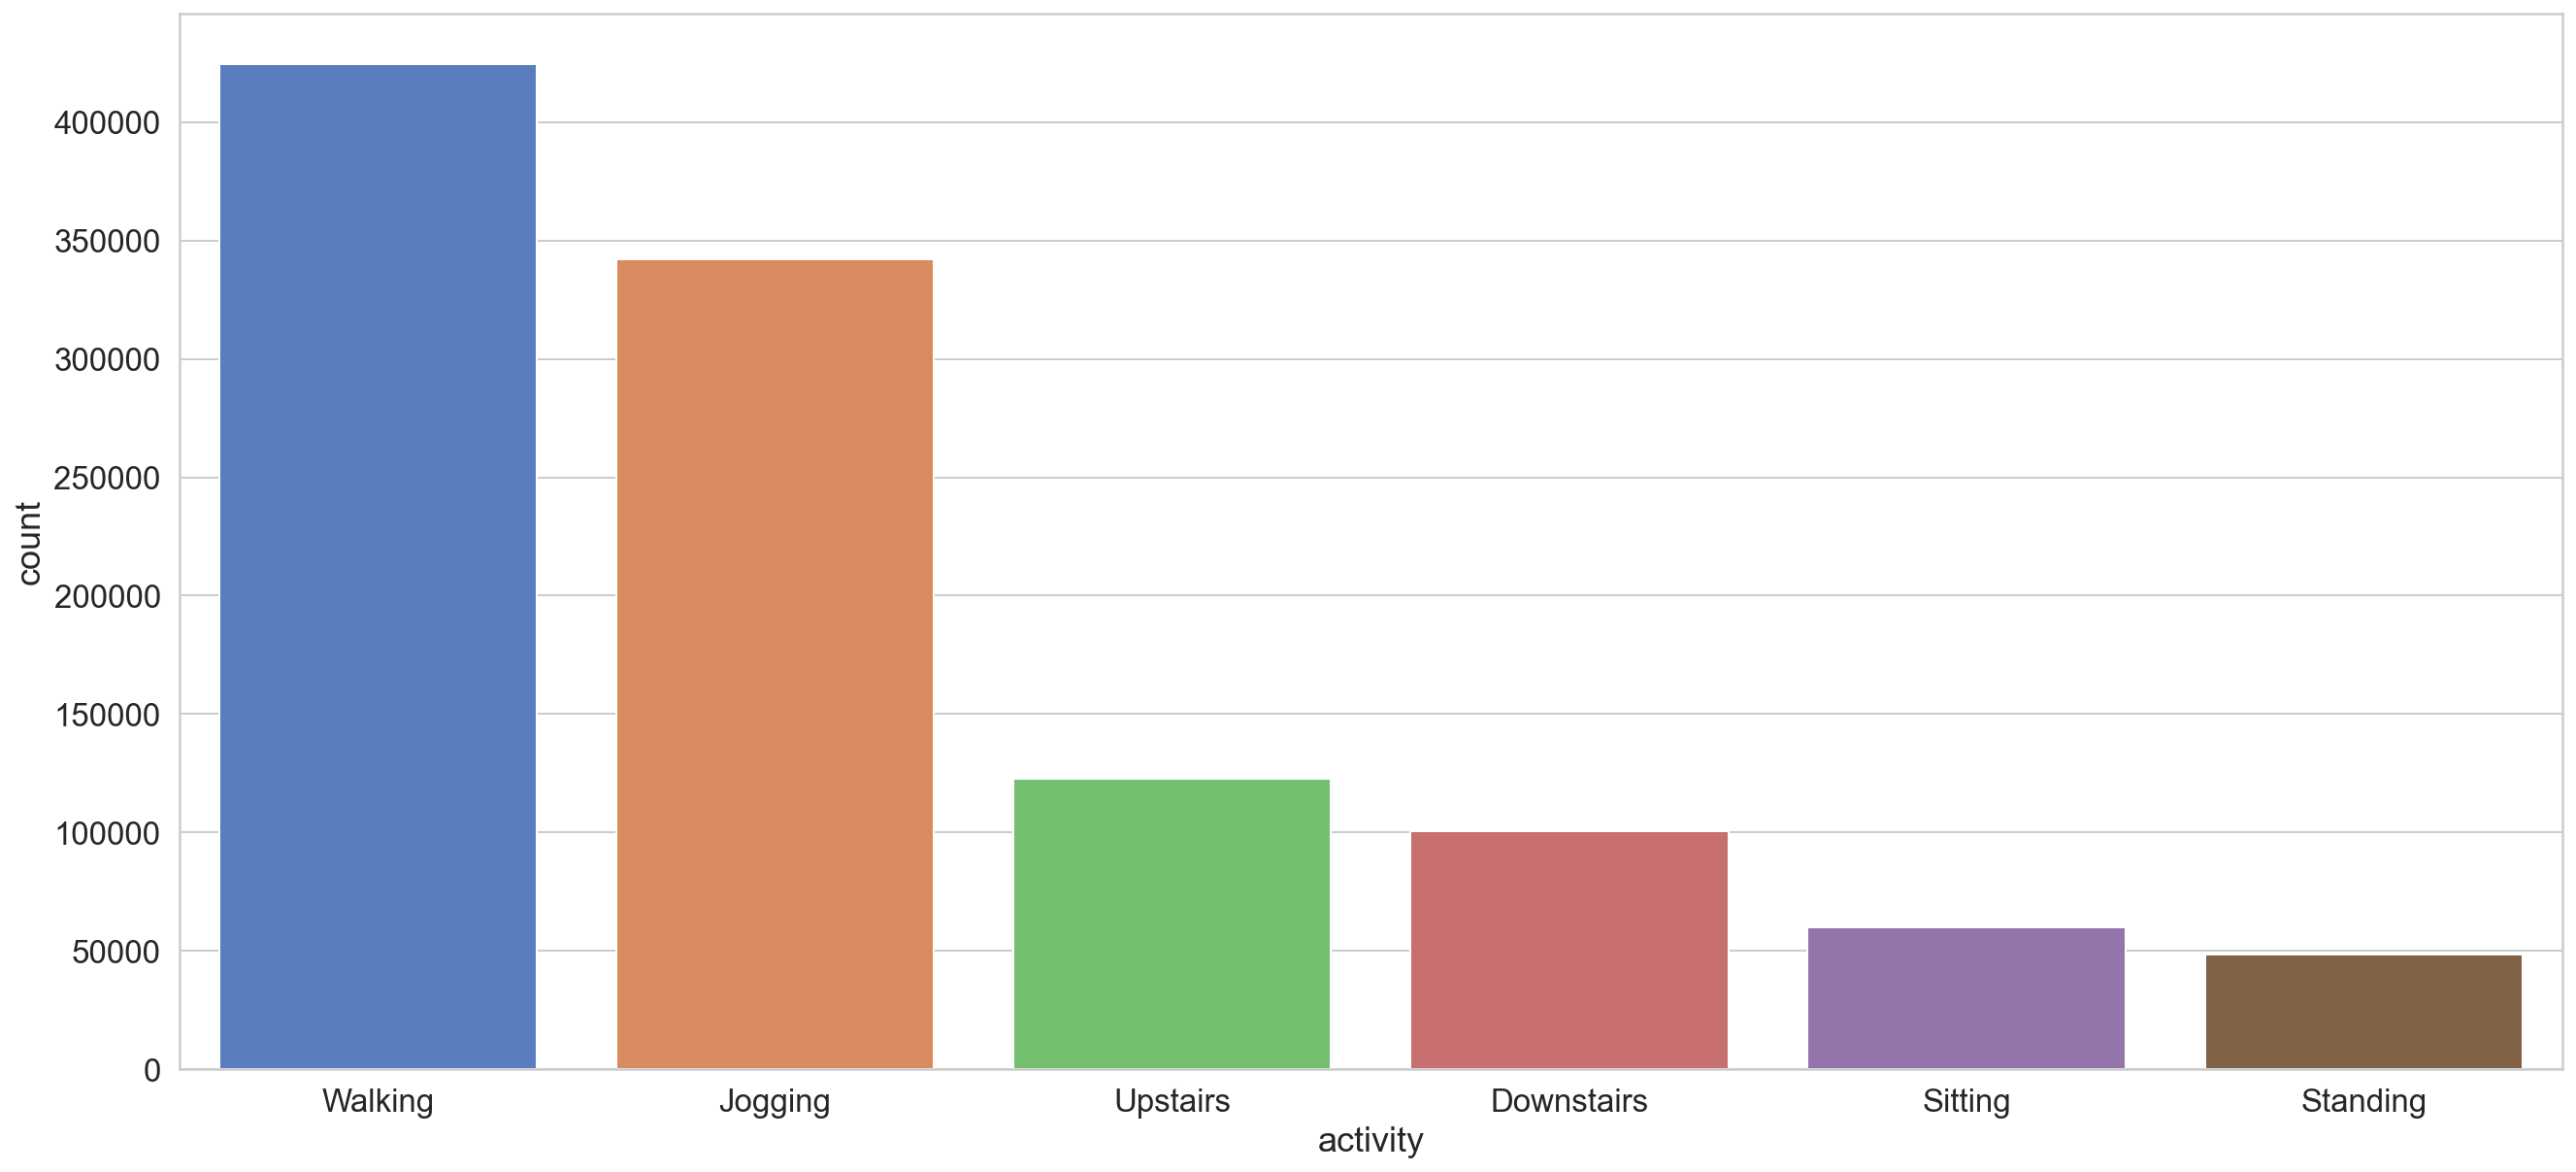

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index);

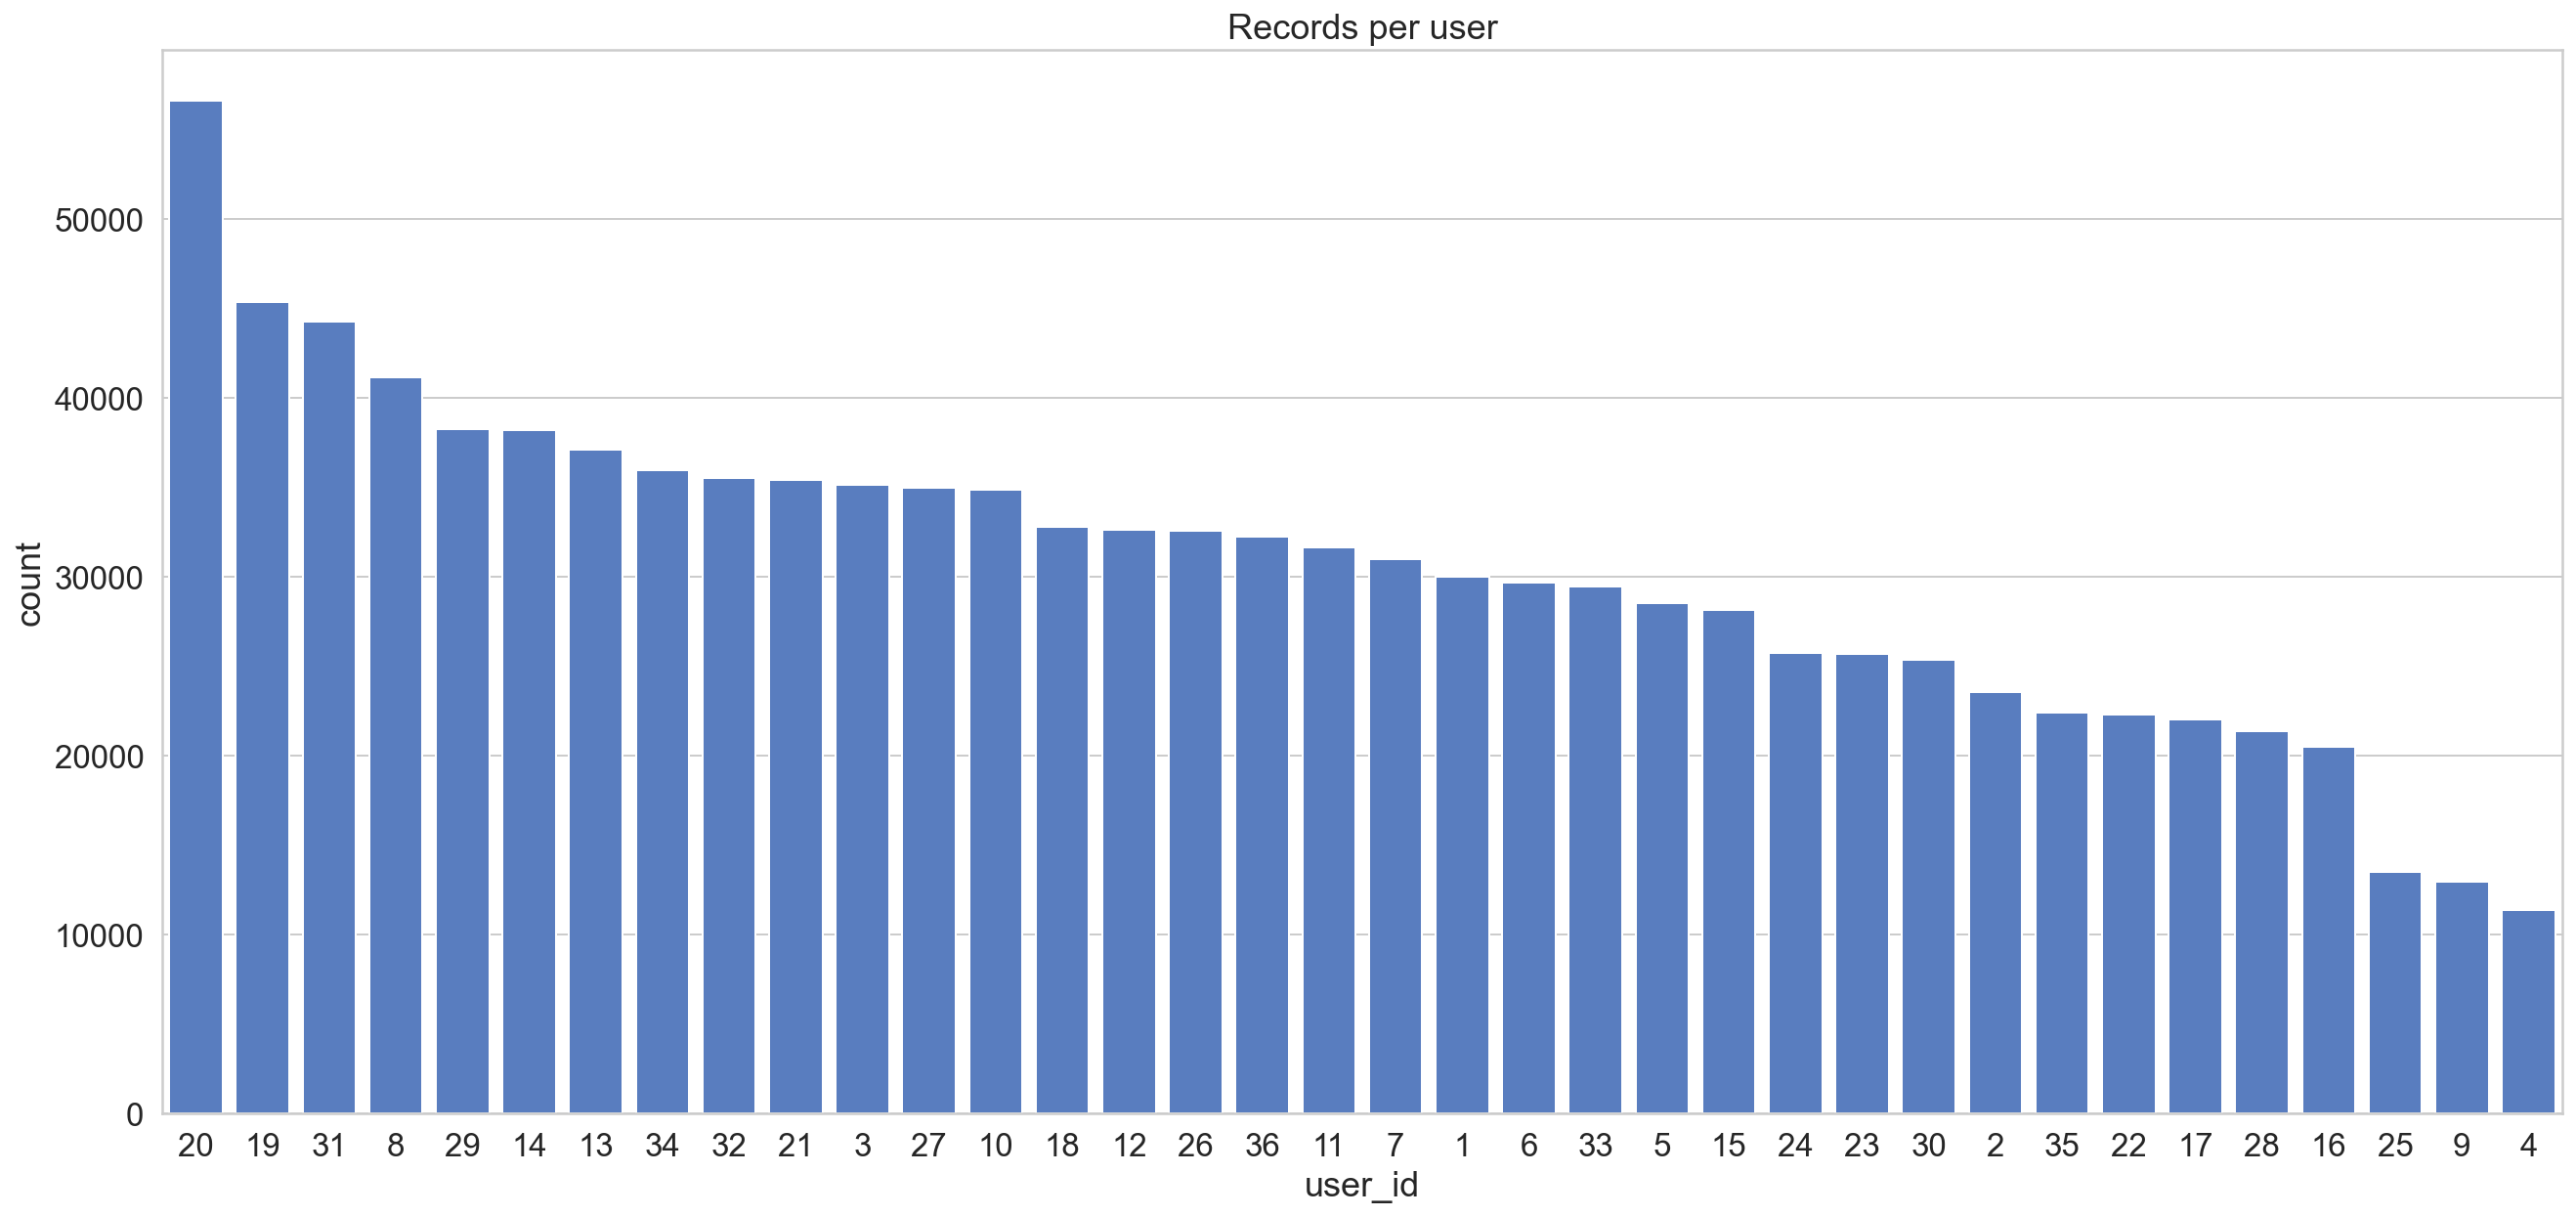

In [135]:
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index);
plt.title("Records per user");

Inspecting the time series data...

In [136]:
cols = ['x_axis', 'y_axis', 'z_axis']

In [137]:
def plot_activity(activity, df, cols):
    data = df[df['activity'] == activity][cols][:400]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

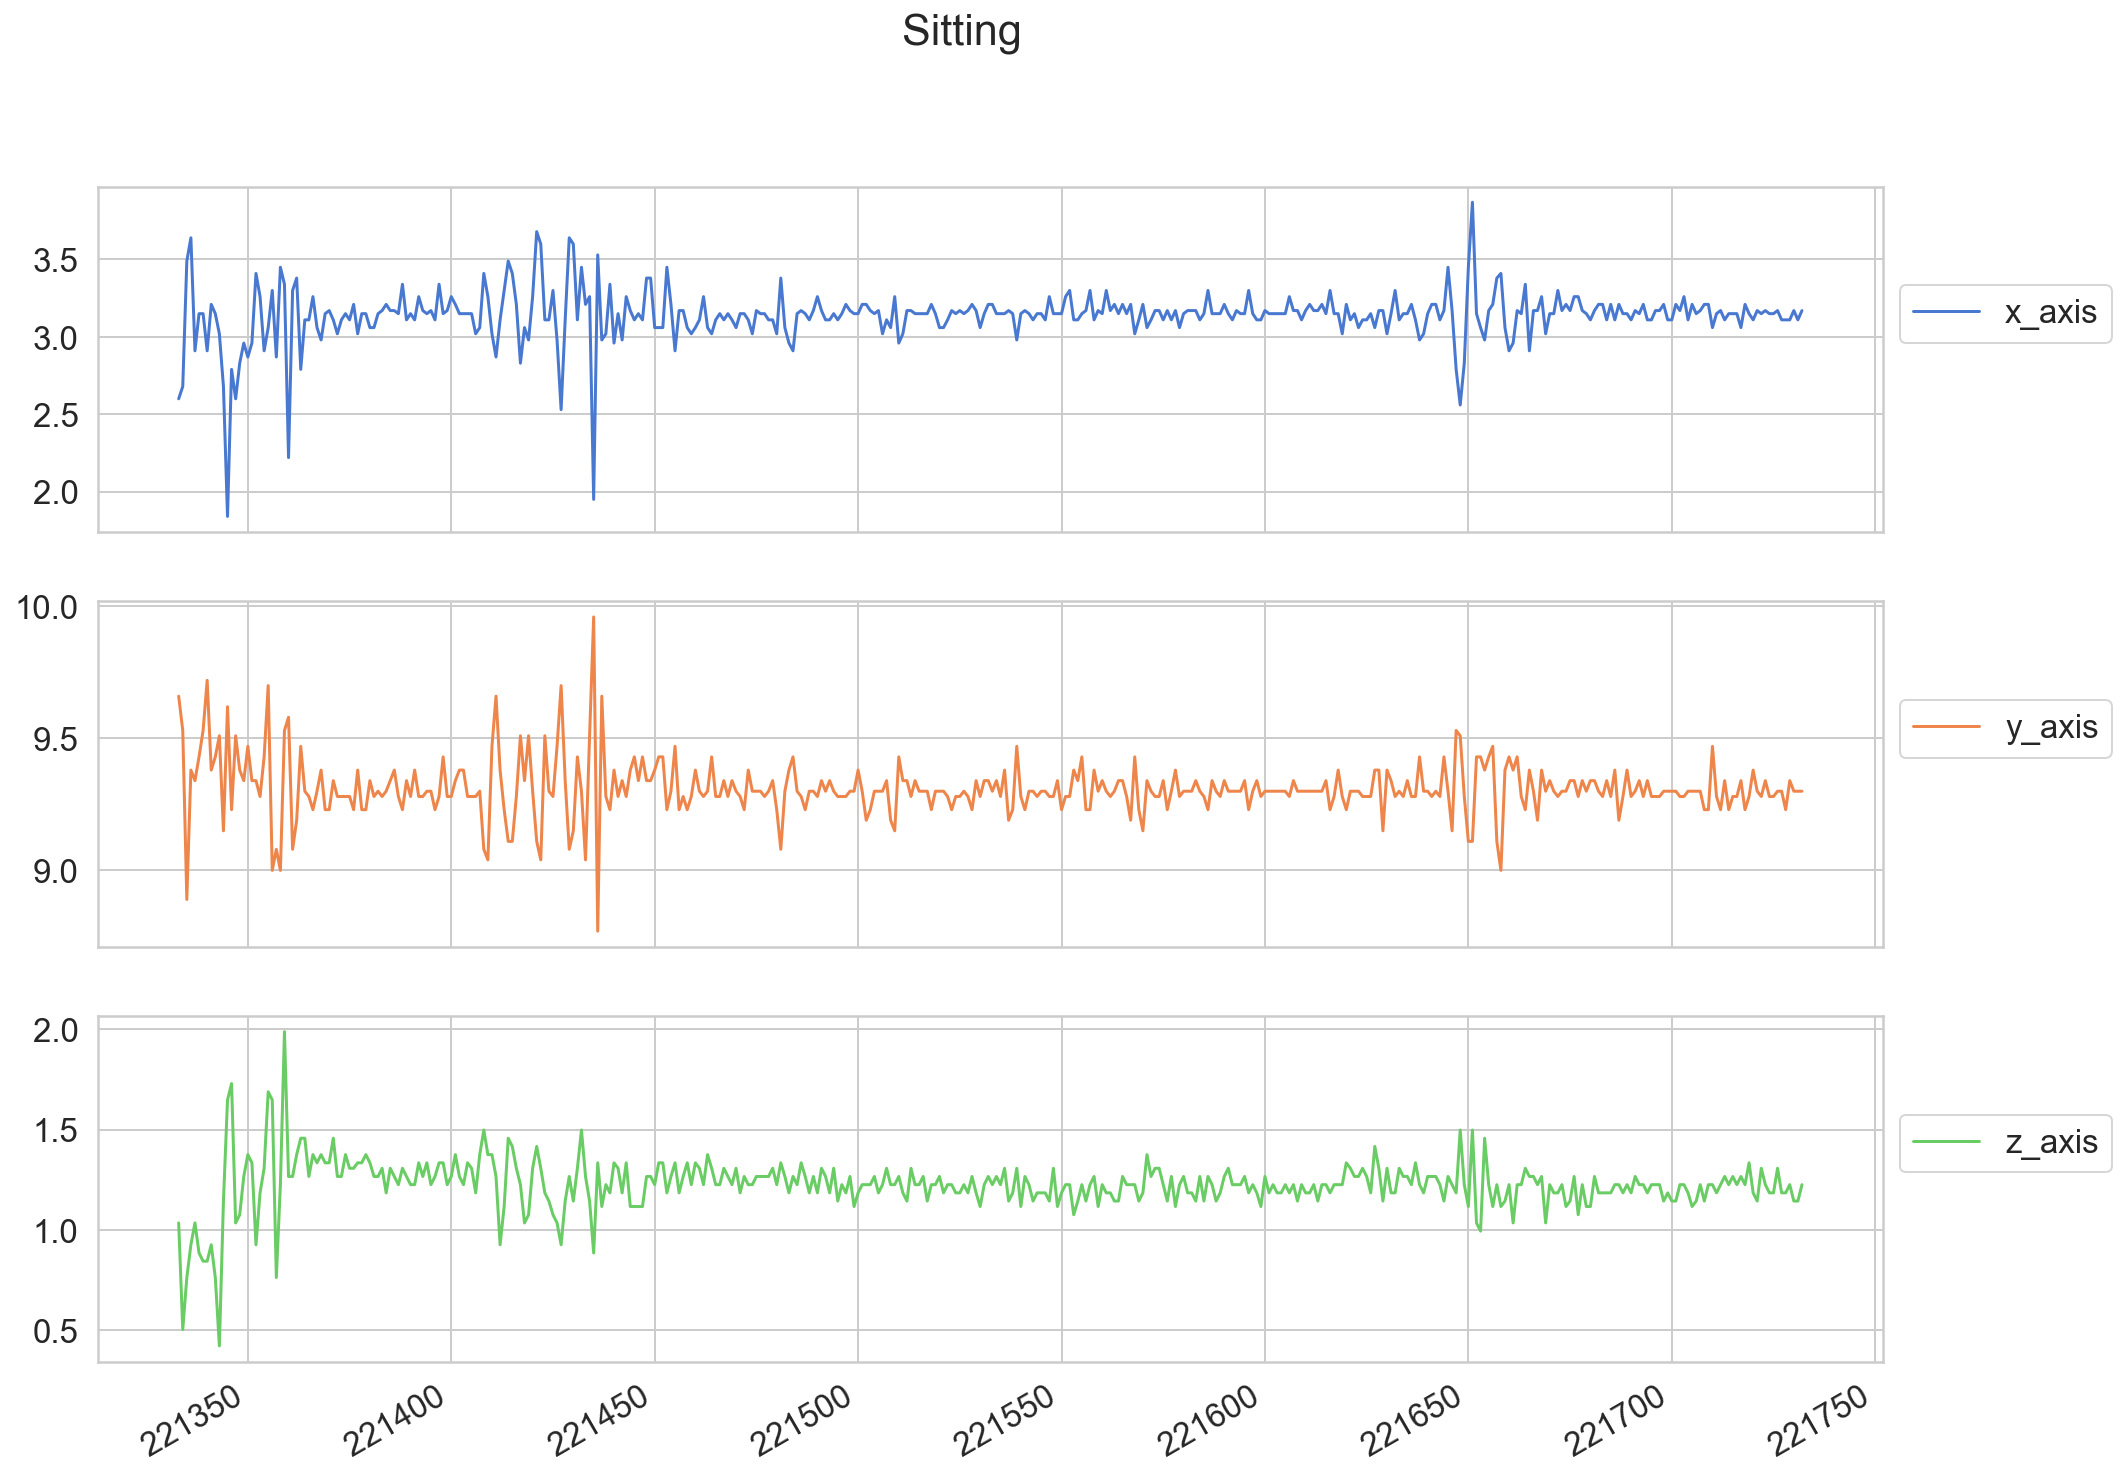

In [138]:
plot_activity("Sitting", df, cols);

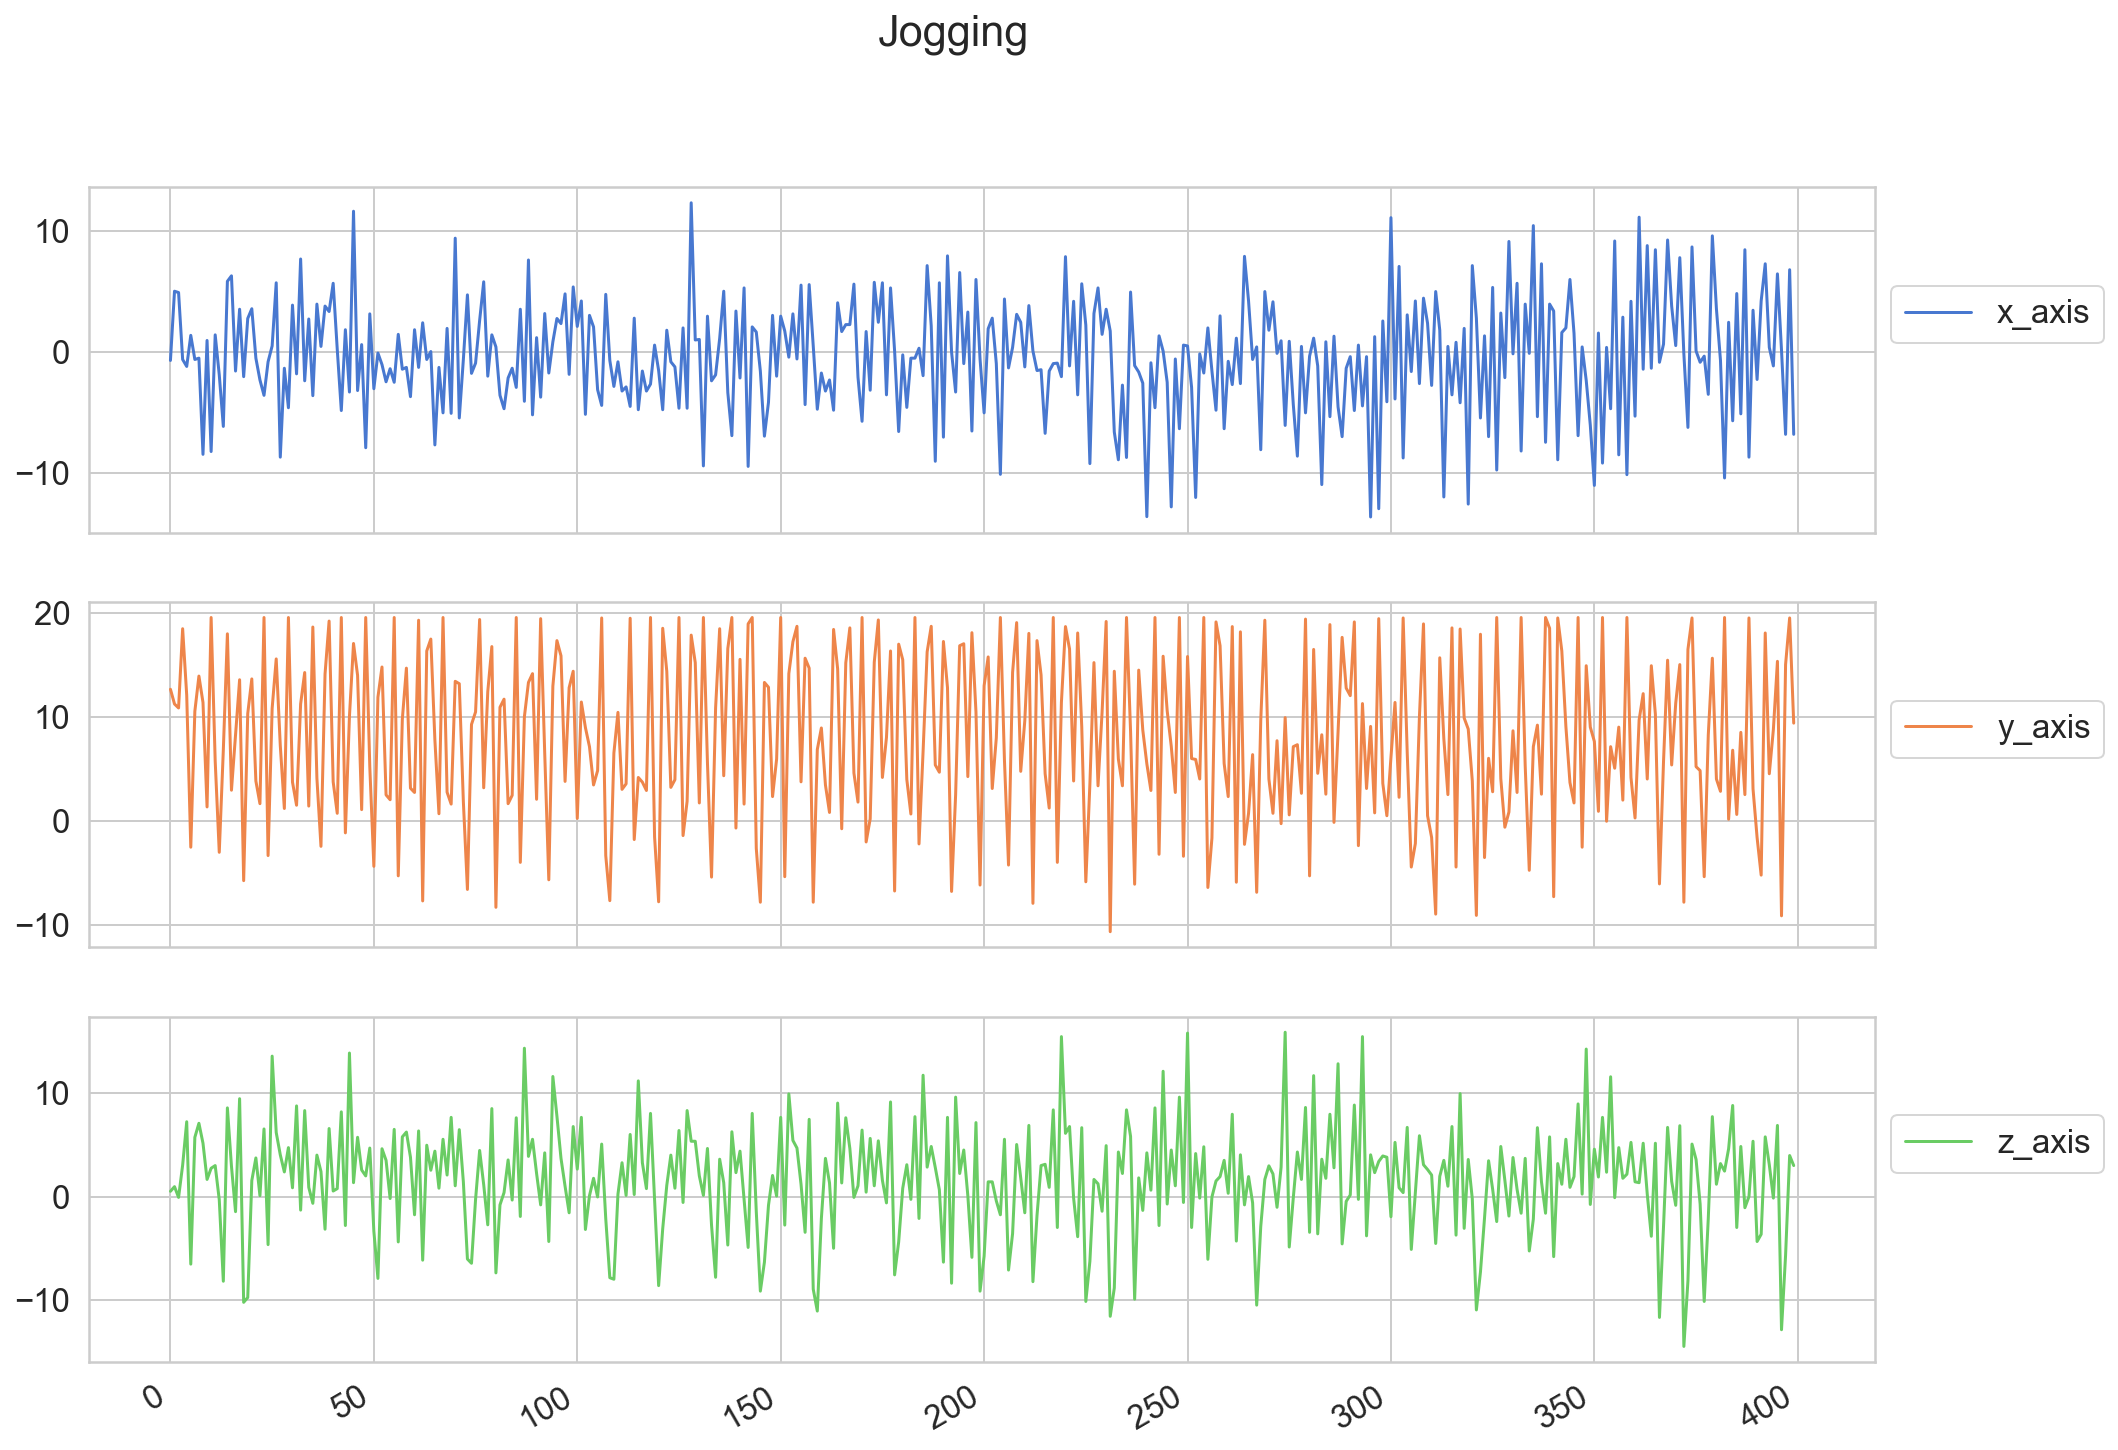

In [139]:
plot_activity("Jogging", df, cols);

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

In order to work with this data, we will need to do some pre-processing such that all axis are scaled correctly.

Furthermore there is another bit of "pre-processing" required such that we can use `keras` library for Deep Learning and classification. We need to split our dataset into a _train_ and _test_ (and _validation_) set and we will need to **one-hot** encode our targets.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets. With time-series data, it is very important not to allow for data to overlap from train to test, i.e we want to avoid the dreaded data leakage problem.

For this we shall first split the data into a train/val/test set, and _then_ apply a windowing function to create small time segments we can then use for training and testing

In [140]:
# df_train = df[df['user_id'] <= 30]
# df_test = df[df['user_id'] > 30]
# df_train.shape, df.shape

In [141]:
def train_val_test_split(df, cols):
    
    features = df[cols]
    column_indices = {name: i for i, name in enumerate(features.columns)}

    n = len(df)
    df_train = df[0:int(n*0.8)].copy()
    df_val = df[int(n*0.8):int(n*0.95)].copy()
    df_test = df[int(n*0.95):].copy()

    num_features = features.shape[1]
    
    return df_train, df_val, df_test, num_features

In [142]:
cols, df.head()

(['x_axis', 'y_axis', 'z_axis'],
    user_id activity       timestamp    x_axis     y_axis    z_axis
 0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953
 1       33  Jogging  49106062271000  5.012288  11.264028  0.953424
 2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722
 3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717
 4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164)

In [143]:
df_train, df_val, df_test, num_features = train_val_test_split(df, cols)
print(num_features) # Should = 3 in this case

3


In [144]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_val.loc[:, scale_columns] = scaler.transform(df_val[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

In [145]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [146]:
df_train.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.155971,0.532131,0.082579
1,33,Jogging,49106062271000,0.672320,0.363899,0.170129
2,33,Jogging,49106112167000,0.656506,0.318605,-0.031501
3,33,Jogging,49106222305000,-0.144110,1.222854,0.573389
4,33,Jogging,49106332290000,-0.227136,0.464191,1.387868


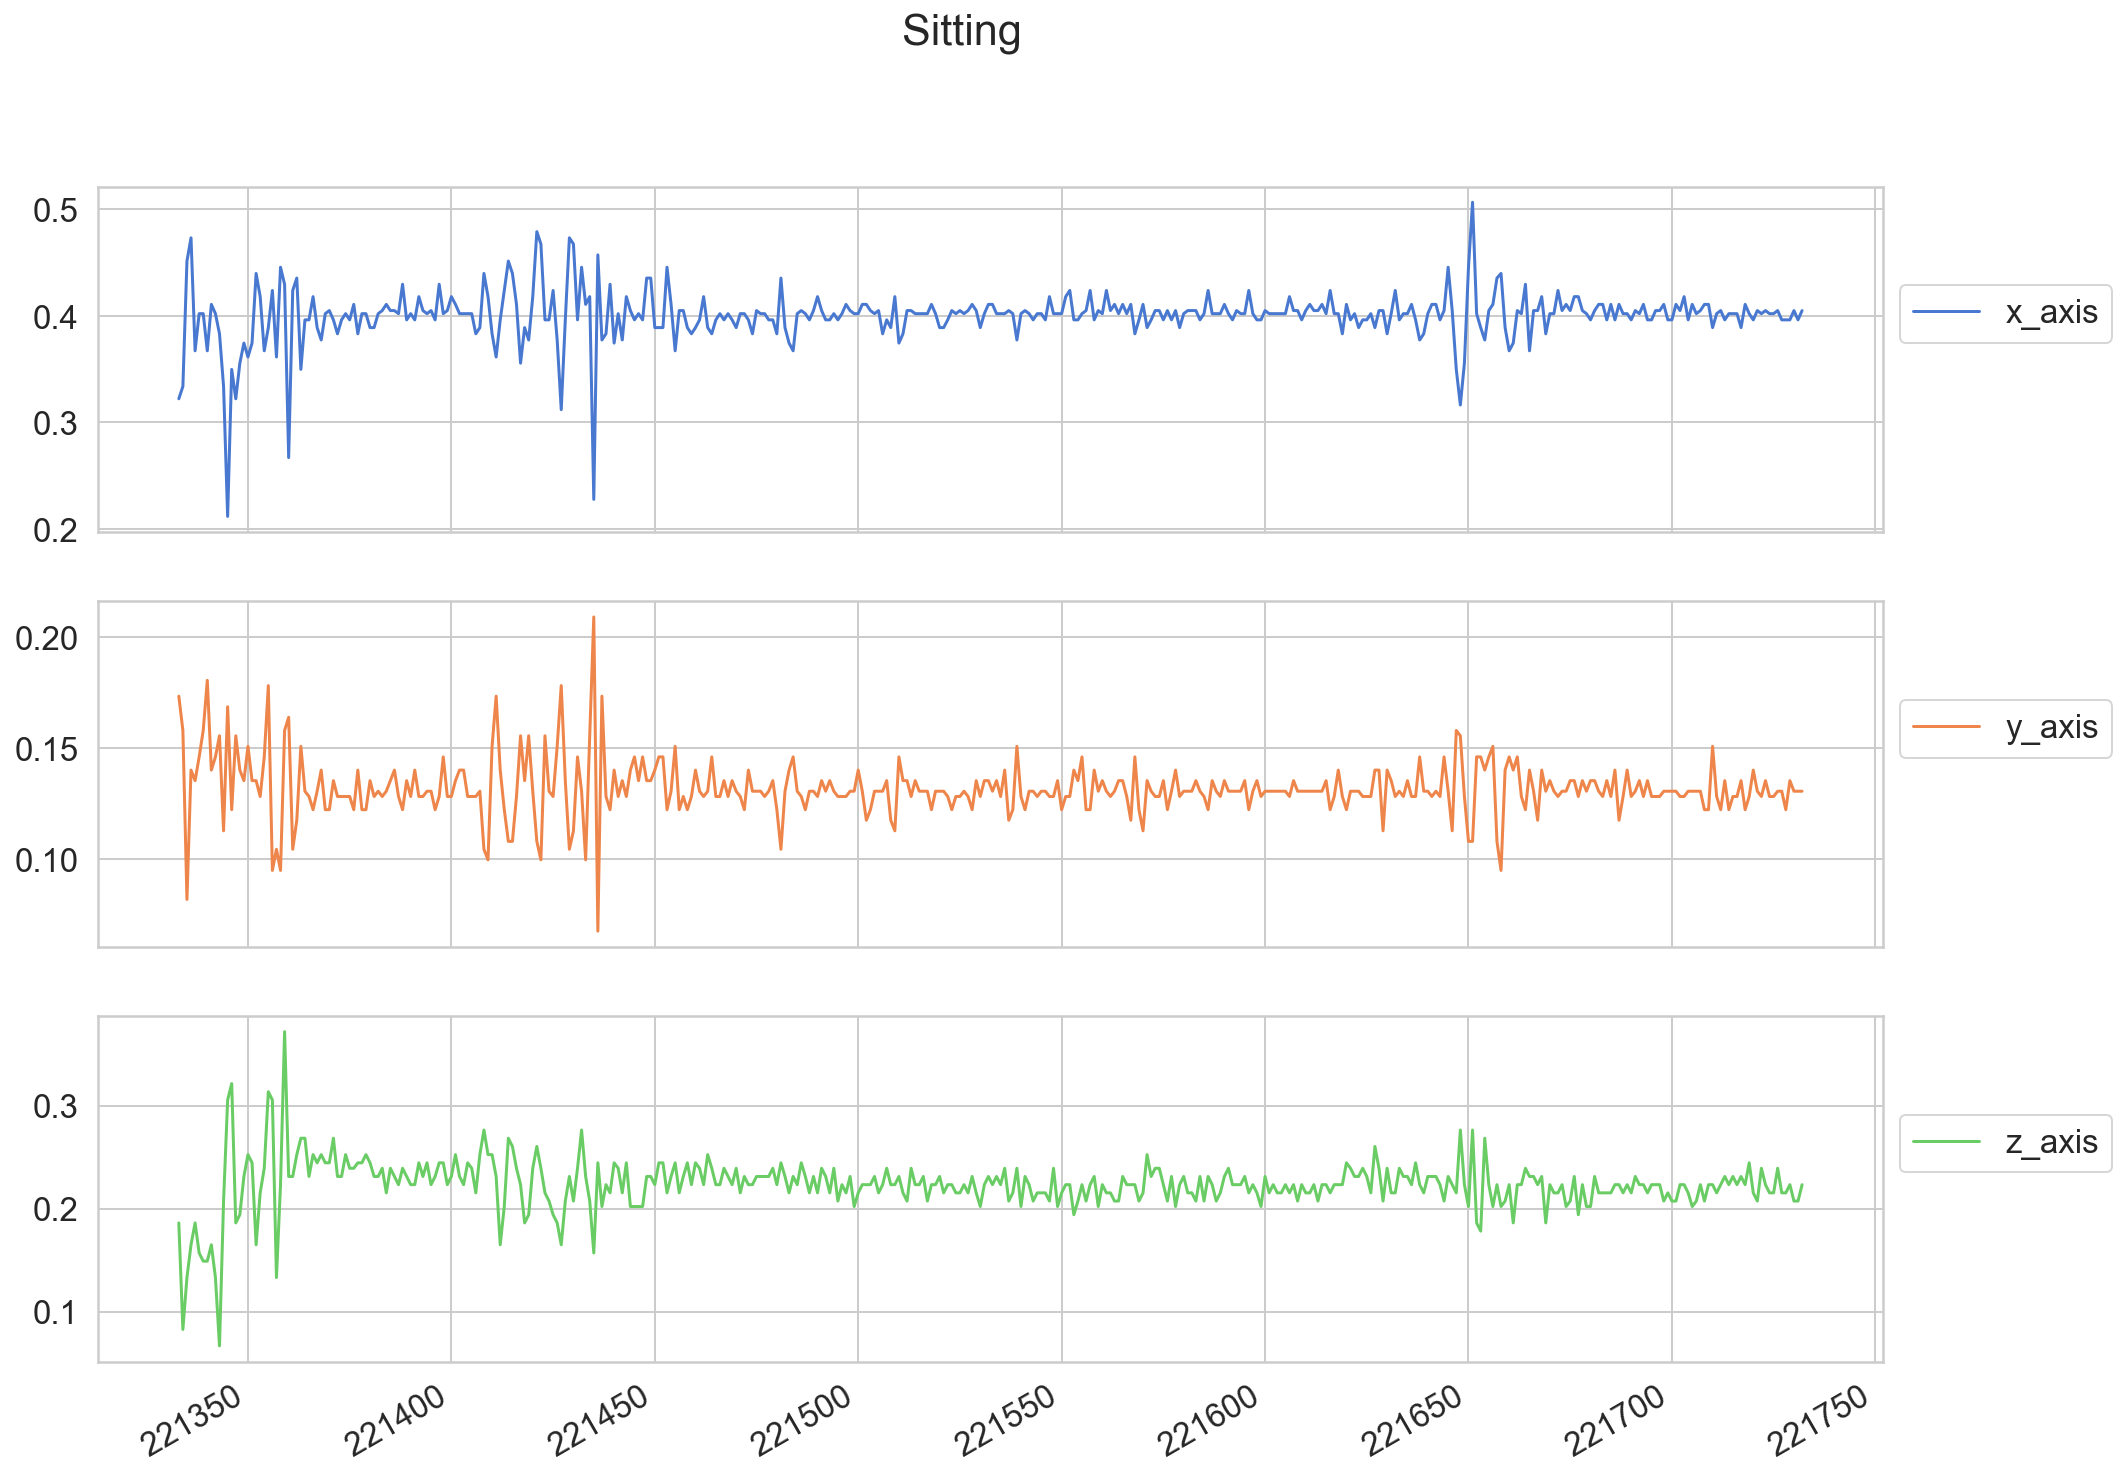

In [147]:
plot_activity("Sitting", df_train, cols);

In [148]:
df_train[cols].keys()

Index(['x_axis', 'y_axis', 'z_axis'], dtype='object')

In [149]:
df_train[['x_axis', 'y_axis', 'z_axis']].keys()

Index(['x_axis', 'y_axis', 'z_axis'], dtype='object')

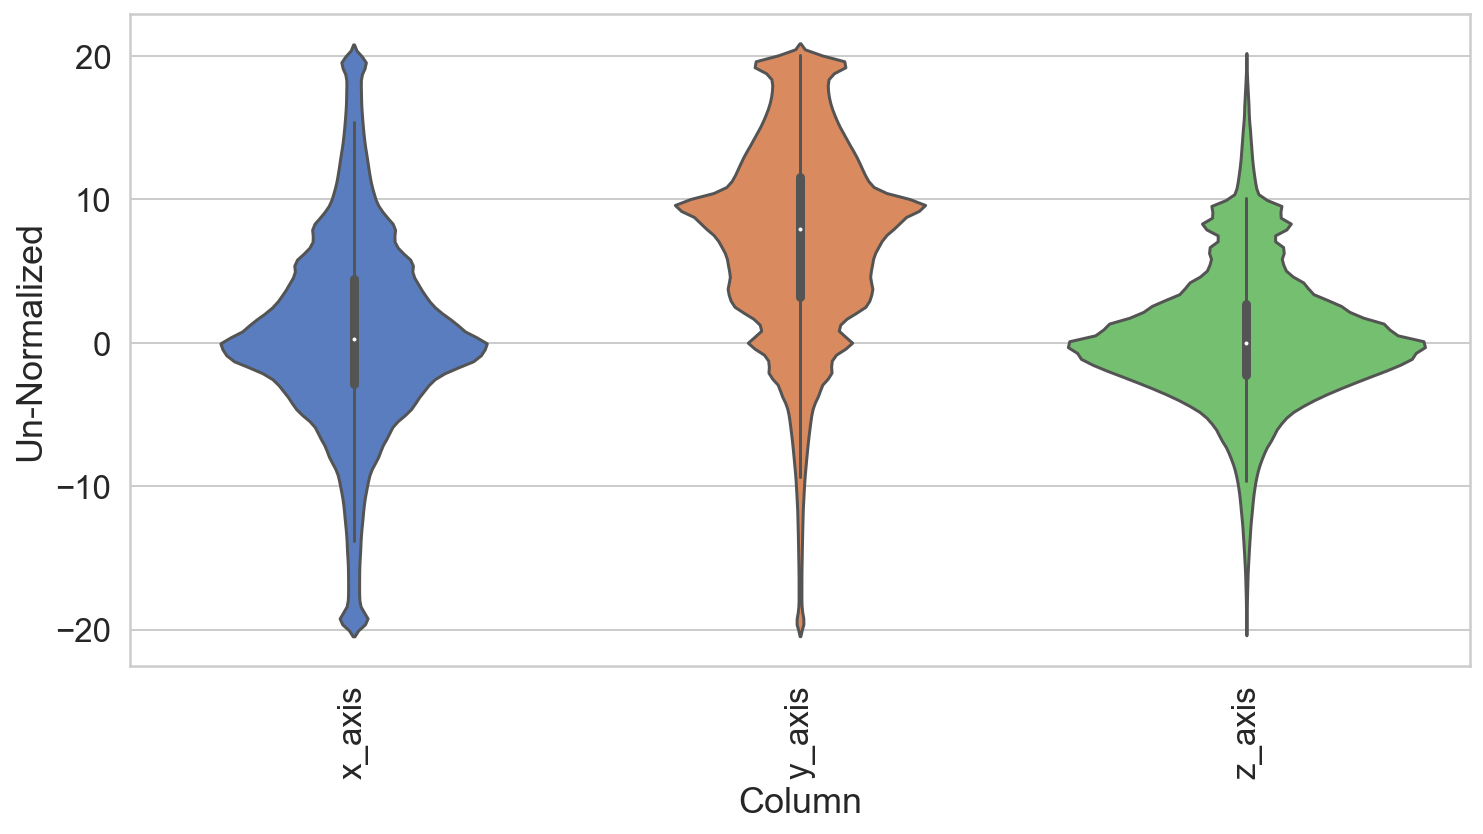

In [150]:
df_dist = df[['x_axis', 'y_axis', 'z_axis']].melt(var_name='Column', value_name='Un-Normalized')

df_dist.dropna(inplace=True)
df_dist = df_dist.astype({'Un-Normalized': 'float'})

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Un-Normalized', data=df_dist)
_ = ax.set_xticklabels(df[['x_axis', 'y_axis', 'z_axis']].keys(), rotation=90)

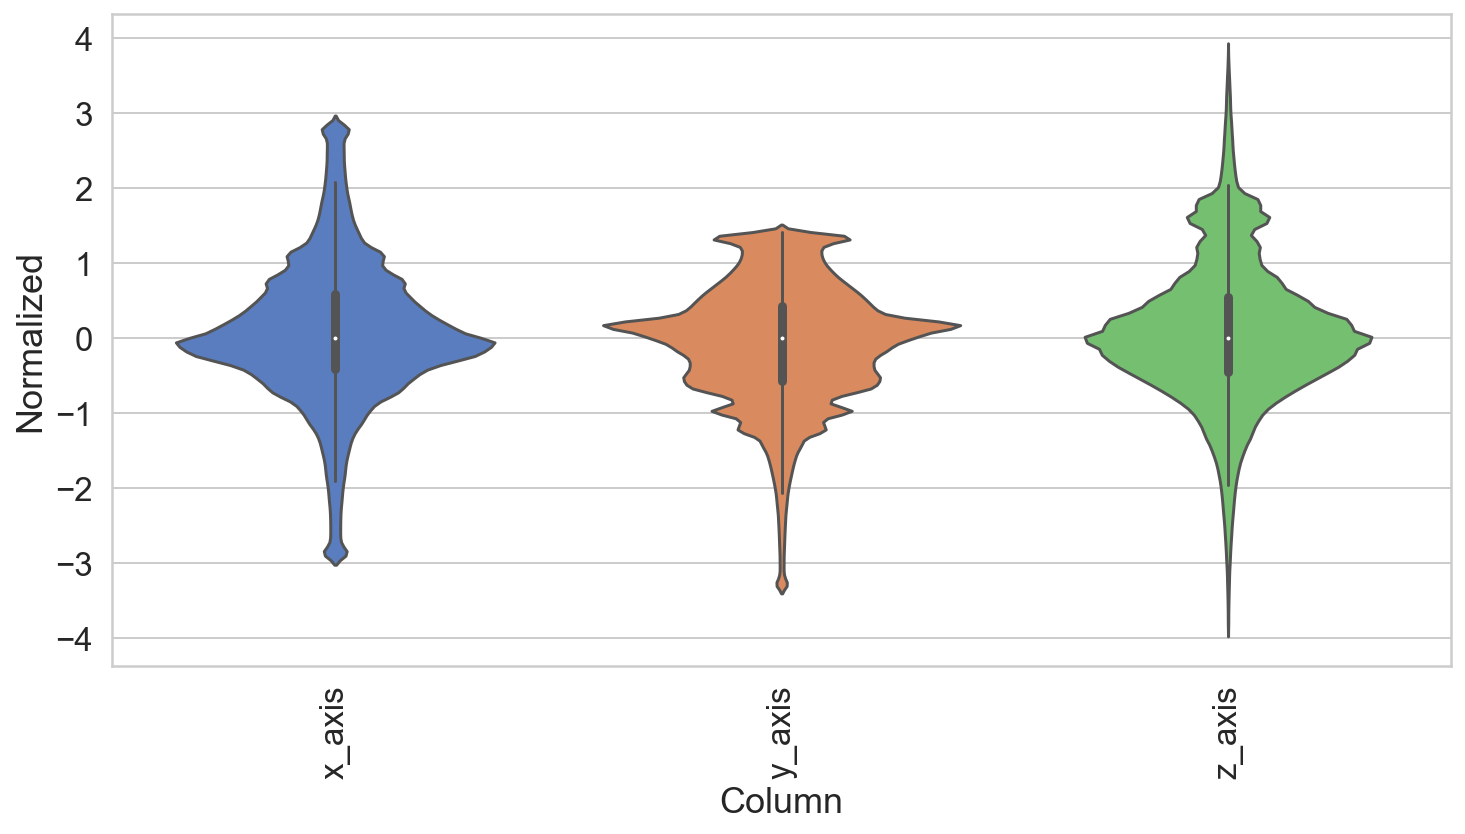

In [151]:
df_norm = df_train[['x_axis', 'y_axis', 'z_axis']].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_norm)
_ = ax.set_xticklabels(df_train[['x_axis', 'y_axis', 'z_axis']].keys(), rotation=90)

Much better! Now let's apply the windowing function...

In [152]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_val, y_val = create_dataset(
    df_val[['x_axis', 'y_axis', 'z_axis']], 
    df_val.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [153]:
print(X_train.shape, y_train.shape)

(21960, 200, 3) (21960, 1)


And finally, one-hot encoding...

In [154]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)

In [155]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(21960, 200, 3) (21960, 6)
(4114, 200, 3) (4114, 6)
(1368, 200, 3) (1368, 6)


What we have now is a dataset of the shape above: (22454, 200, 3) (22454, 6) for `X_train` and `y_train` respectivly. 

This is to say we have 22452 _batches_, that are 200 time-step windows, that contain 3 variables each, i.e. `x, y, z` measurements. As you may have guess alreeady, this could be translated to X-number of _batches_, that are X-*MJD* day length windows, each containing 6 pass-band filter measurements.

## What is the Transformer achitecture?

The overall architecture of the Transformer network can be seen below. It consists of the _encoder_ section and a _decoder_ section

<img src="./images/transformer-arch.png" height=40% width=40%>

In the first instance, we will implement just the _encoder_ section show here and add a softmax output:

<img src="./images/transformer-arch-encoder.png" height=30% width=30%>

Depending on results and if we are able to get the inputs to behave, we will move towards development and analysis of the full Transformer architecture for time series.

In [156]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Implement multi head self attention as a Keras layer

In [157]:
# This has been pulled verbatim from the Keras documatation page: 
# https://keras.io/examples/nlp/text_classification_with_transformer/

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

The above can be seen pictorially as follows:
<img src="./images/transformer-arch-multihead.png" height=30% width=30%>

In [158]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [214]:
embed_dim = 32  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

## Adapting the Transformer for Time-Series

The Transformer architeecture was originally applied to NLP tasks of translation. For this, there were specific stages in the pipeline that are focused towards working with words. For example, the embedding layer would project each word into a high-dimensional vector space followed by a positional enciding layer to ensure sequential information is preversed.

In the case of time-series, a simple Dese layer can be used to map the (`m, T, 6`)(batch, time-steps, features) into a (`m, 32`)(batch, time-steps x features). In `keras`, in order to apply a Dense layer to each input in the time sequence, there is `TimeDistributed` layer.  

From "Hands-On Machine Learning" by Aurelien Geron

> The `TimeDistributed` layer wraps any layer (e.g. `Dense` layer) and applies it at every time step of its input sequence. It does this efficiently, by reshaping the inputs so that each time step is treated as a seperate instance ( i.e, it reshapes the inputs from [*batch size, time-steps, input dimension*] to [*batch size x time-steps, input dimensions].

...
> The `Dense` layer actually supports sequences as inputs (and even higher dimensional inputs): it handles them just like `TimeDistributed(Dense(...))`, meaning it is applied to the last input dimension only (independently accross all time steps). Thus, we could just replace ... with just `Dense(..)`

> Note that a `TimeDistributed(Dense(n))` layer is equivalent to a `Conv1D(n, filter_size=1)` layer.

* https://keras.io/api/layers/convolution_layers/convolution1d/
* https://keras.io/api/layers/recurrent_layers/time_distributed/

##### But what is a 1-D convolition I hear you cry!?

In [195]:
from IPython.display import HTML

HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/vcp0XvDAX68" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

### Build the model

In [196]:
input_shape = X_train.shape 
input_shape[1:] # (TIMESTEPS, num_features) 

(200, 3)

In [225]:
model = keras.Sequential()

# model.add(layers.Dense(units=128))

# Old API
# model.add(layers.Convolution1D(filters=128, kernel_size=16, activation='relu'))
# New Keras API
# model.add(layers.Conv1D(filters=128, kernel_size=16, activation='relu', input_shape=input_shape[1:]))

# Inspired by this line: Note that a TimeDistributed(Dense(n)) layer is equivalent to a Conv1D(n, filter_size=1) layer. 
# Moving kernel_size from 16 to 1
# Each time-step becomes a 32-vector, where one can think of a window of 200 time-steps being equivulent 
# to a sentence in NLP land
model.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=input_shape[1:]))

model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(6, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [226]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val)
)

Epoch 1/20
687/687 [==============================] - 59s 86ms/step - loss: 0.7027 - acc: 0.7552 - val_loss: 1.0472 - val_acc: 0.6706
Epoch 2/20
687/687 [==============================] - 44s 65ms/step - loss: 0.3963 - acc: 0.8546 - val_loss: 1.5087 - val_acc: 0.6281
Epoch 3/20
687/687 [==============================] - 45s 65ms/step - loss: 0.3217 - acc: 0.8830 - val_loss: 1.5200 - val_acc: 0.6276
Epoch 4/20
687/687 [==============================] - 43s 63ms/step - loss: 0.2700 - acc: 0.9045 - val_loss: 1.5741 - val_acc: 0.6077
Epoch 5/20
687/687 [==============================] - 50s 73ms/step - loss: 0.2292 - acc: 0.9193 - val_loss: 1.4357 - val_acc: 0.6351
Epoch 6/20
687/687 [==============================] - 58s 84ms/step - loss: 0.2085 - acc: 0.9265 - val_loss: 1.6693 - val_acc: 0.5532
Epoch 7/20
687/687 [==============================] - 61s 89ms/step - loss: 0.1840 - acc: 0.9367 - val_loss: 1.6639 - val_acc: 0.5870
Epoch 8/20
687/687 [==============================] - 70s 102m

In [227]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 200, 32)           128       
_________________________________________________________________
transformer_block_14 (Transf (None, 200, 32)           6464      
_________________________________________________________________
global_average_pooling1d_13  (None, 32)                0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 20)                660       
_________________________________________________________________
dropout_57 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 6)               

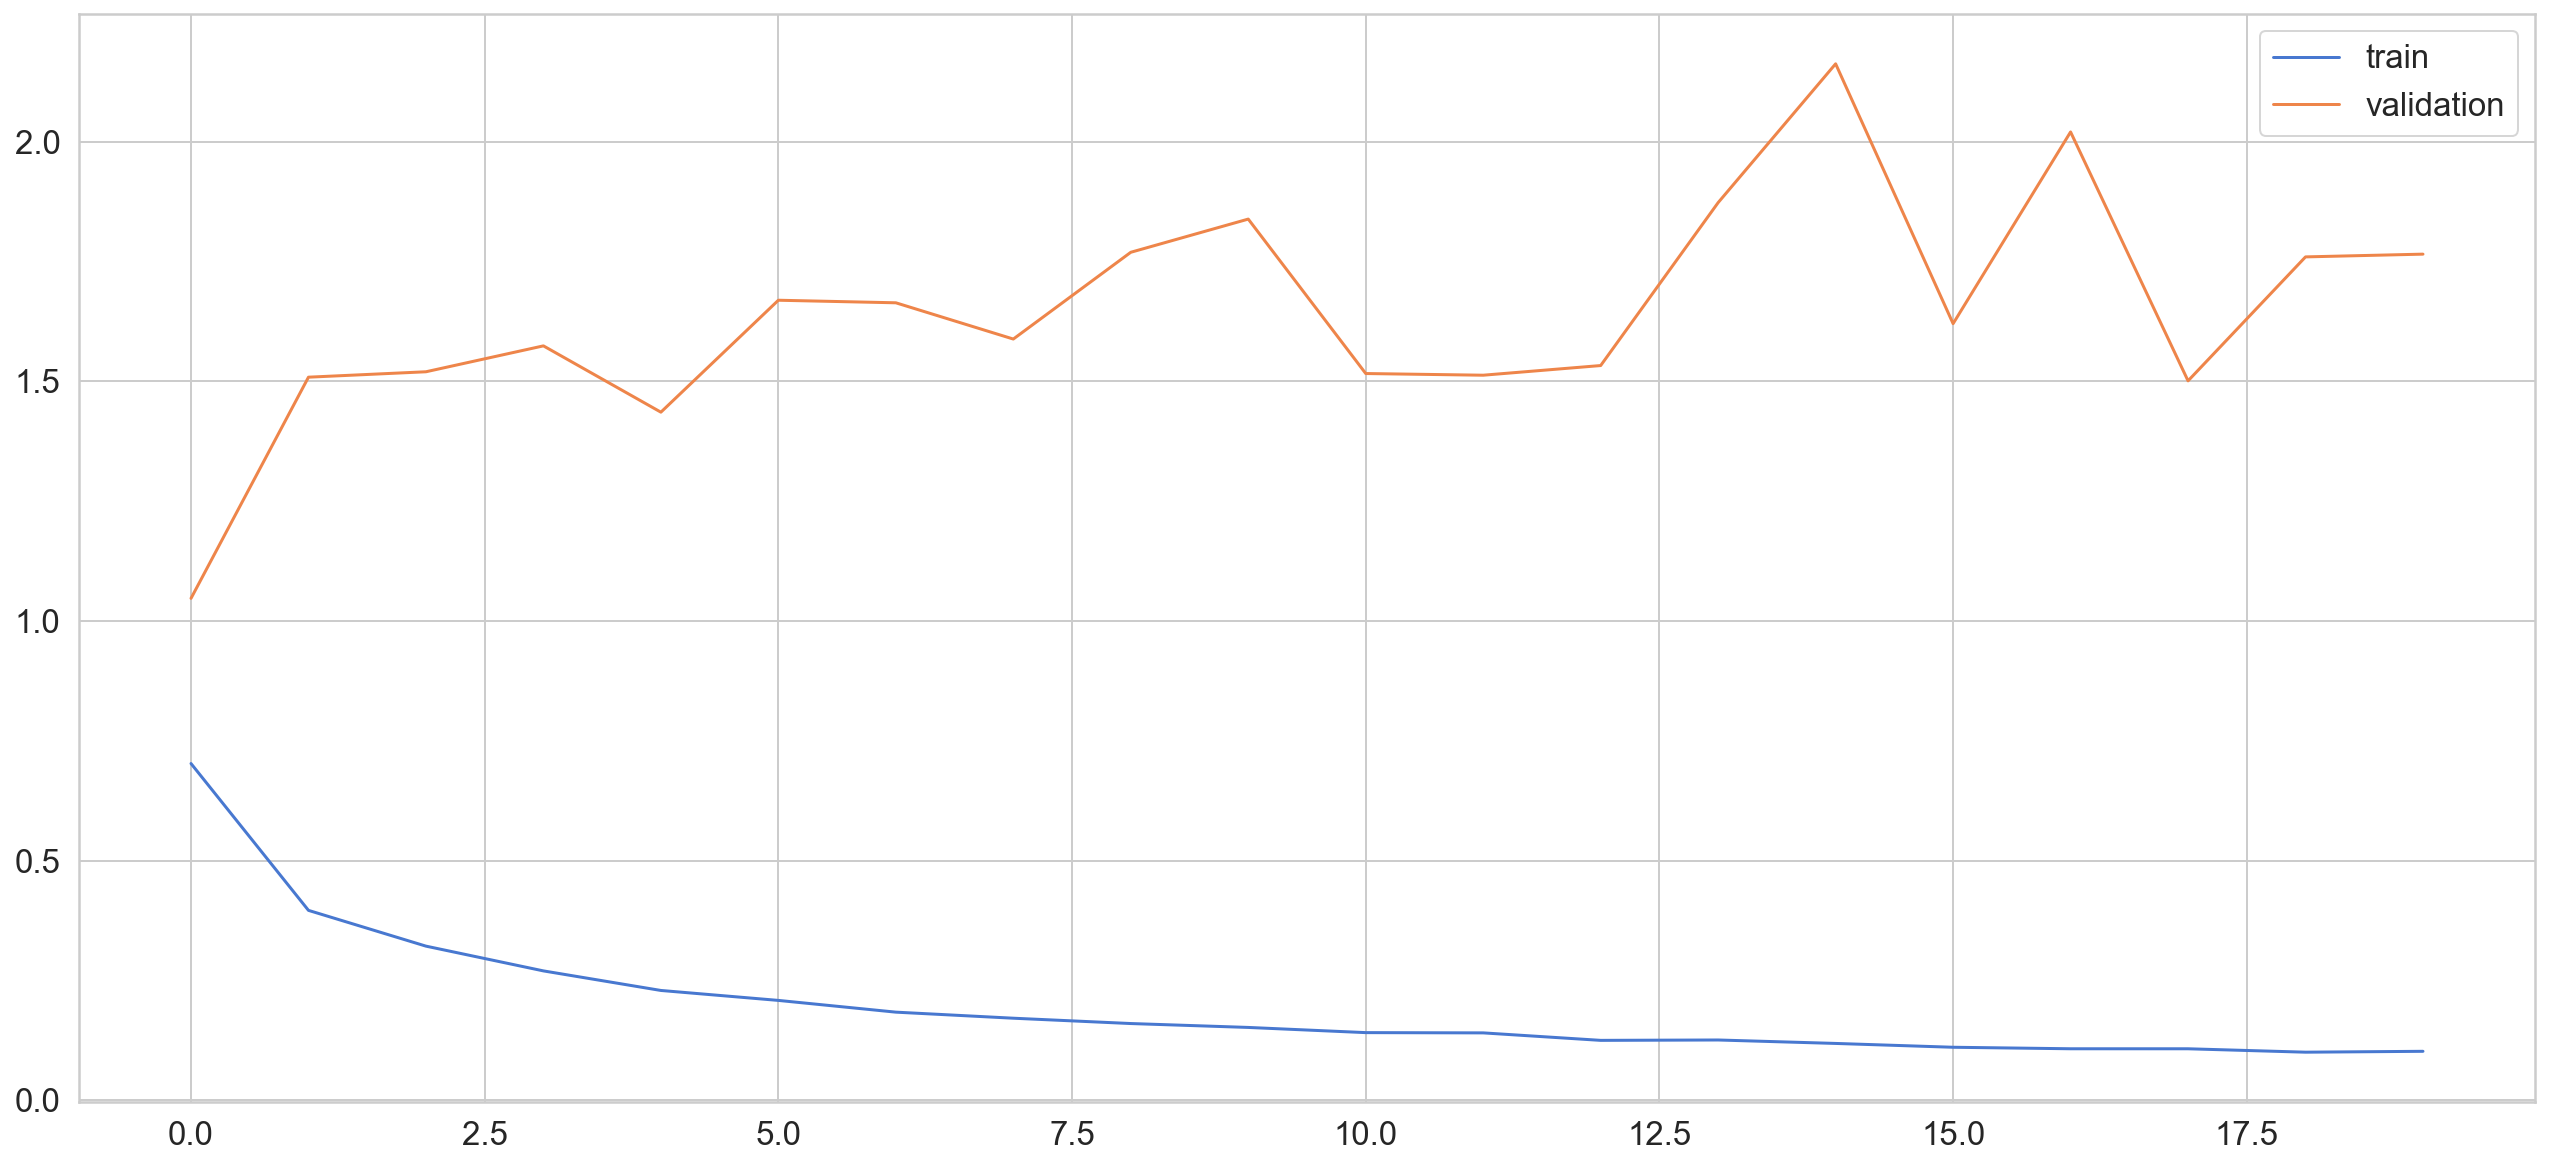

In [228]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

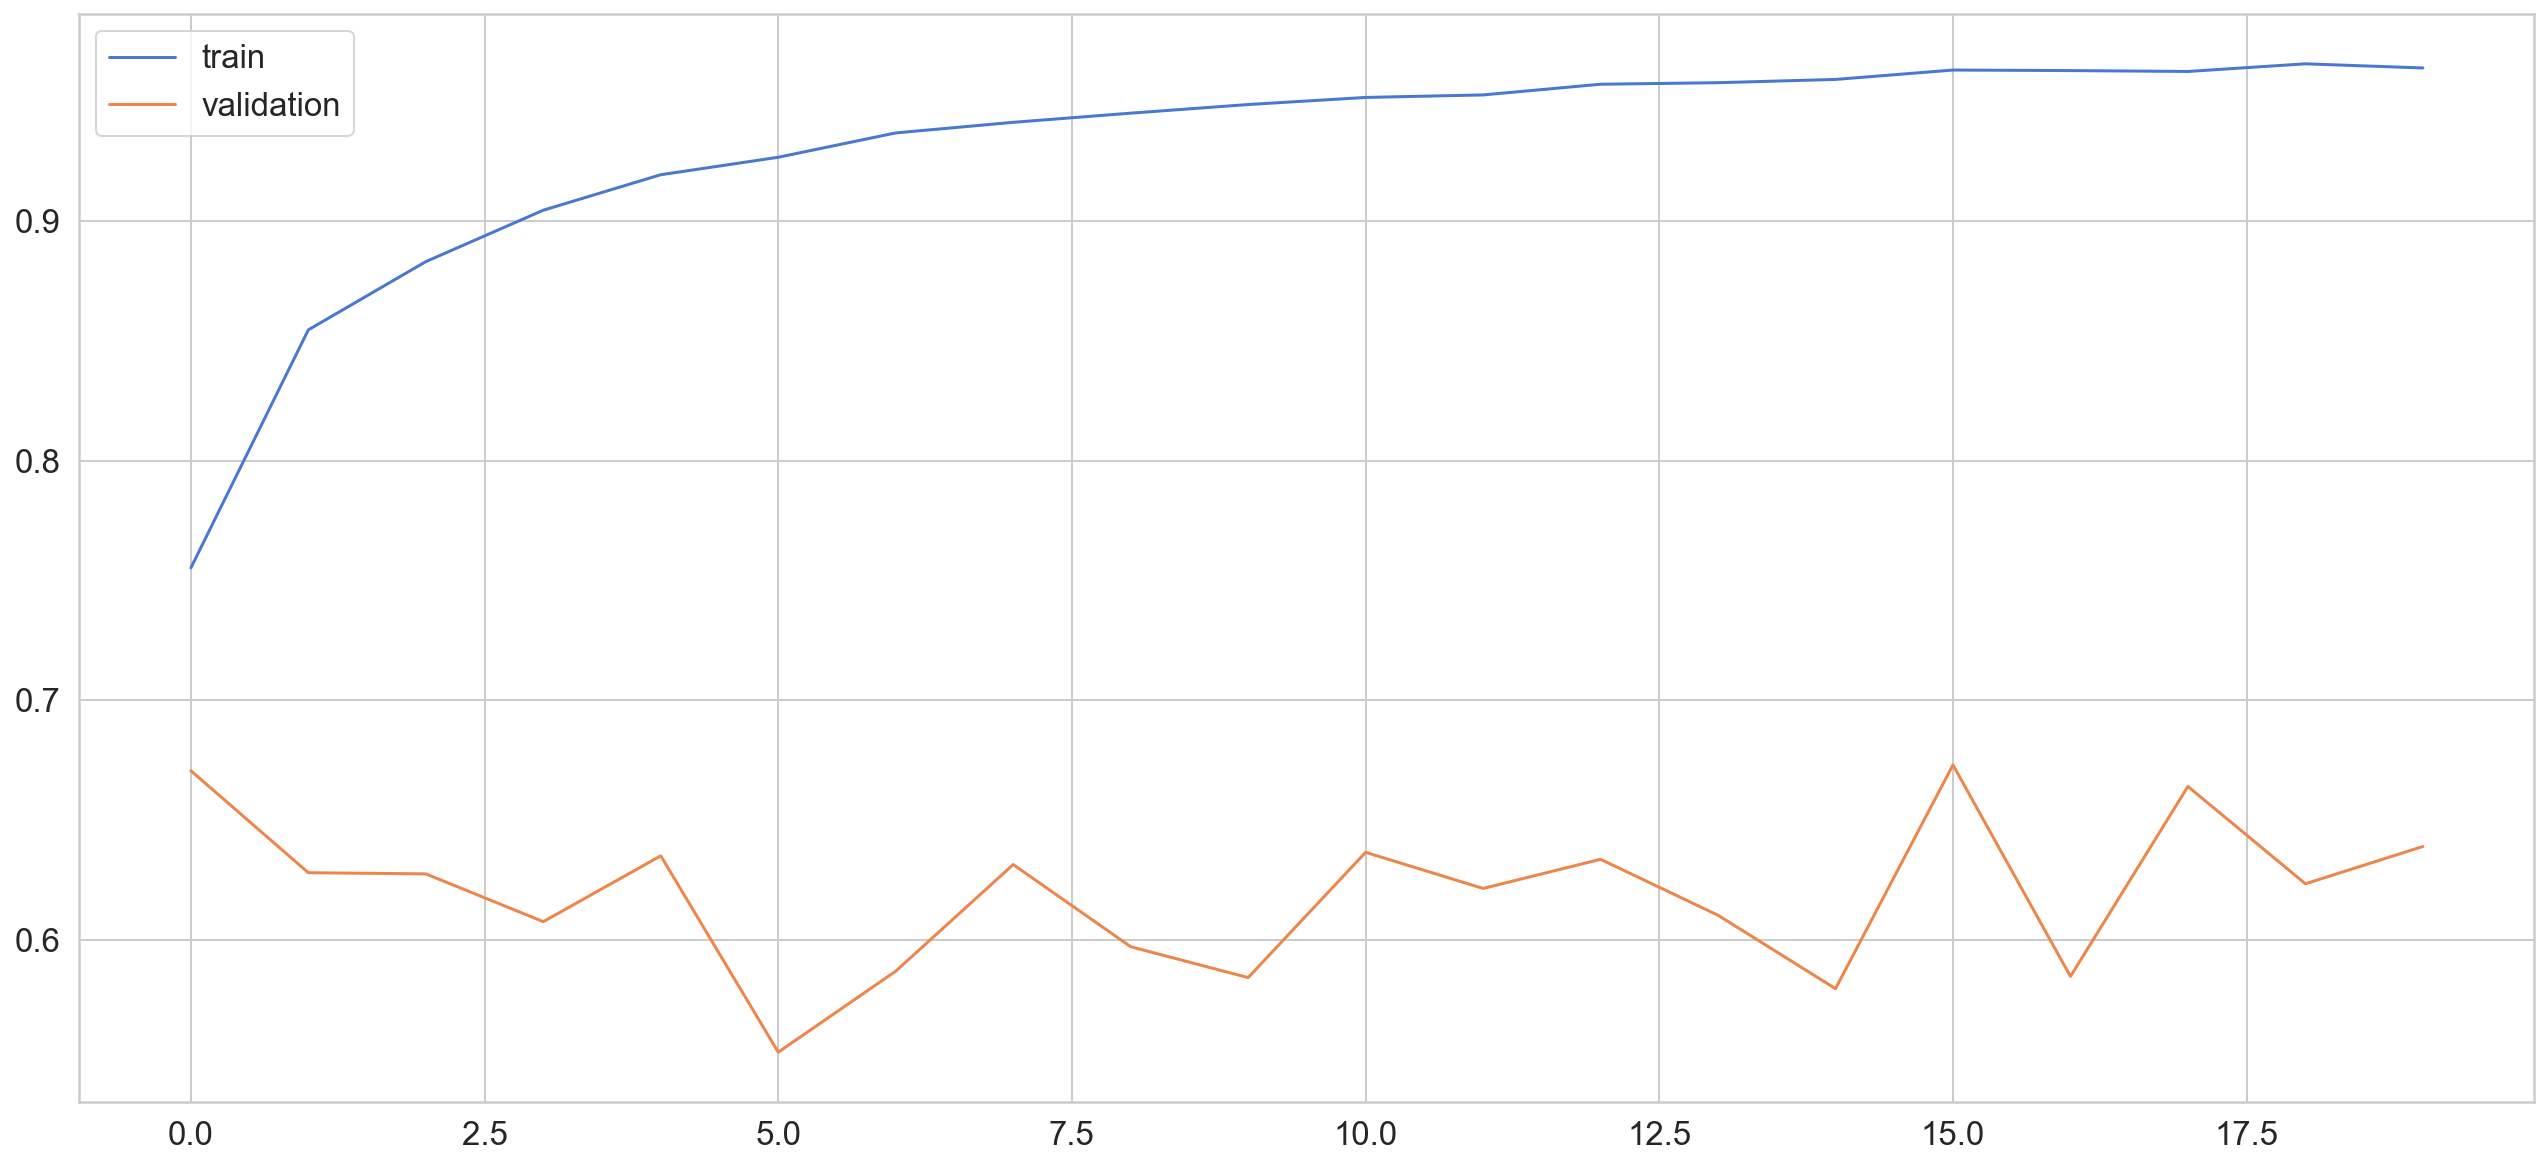

In [229]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend();

In [230]:
model.evaluate(X_test, y_test)

43/43 [==============================] - 1s 19ms/step - loss: 0.9674 - acc: 0.8041


[0.9674445390701294, 0.8040935397148132]

In [231]:
y_pred = model.predict(X_test)

In [232]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm / np.sum(cm, axis=1, keepdims=1), 
      annot=True, 
      # fmt="d", 
      fmt=".2f", 
      # cmap=sns.diverging_palette(220, 20, n=7),
      # cmap="coolwarm",
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

In [233]:
cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
cm / np.sum(cm, axis=1, keepdims=1)

array([[0.16071429, 0.02678571, 0.        , 0.        , 0.13392857,
        0.67857143],
       [0.00246305, 0.9137931 , 0.        , 0.        , 0.08374384,
        0.        ],
       [0.        , 0.        , 0.98387097, 0.01612903, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.98214286, 0.        ,
        0.01785714],
       [0.02873563, 0.05172414, 0.00574713, 0.        , 0.24712644,
        0.66666667],
       [0.        , 0.00227273, 0.        , 0.        , 0.00681818,
        0.99090909]])

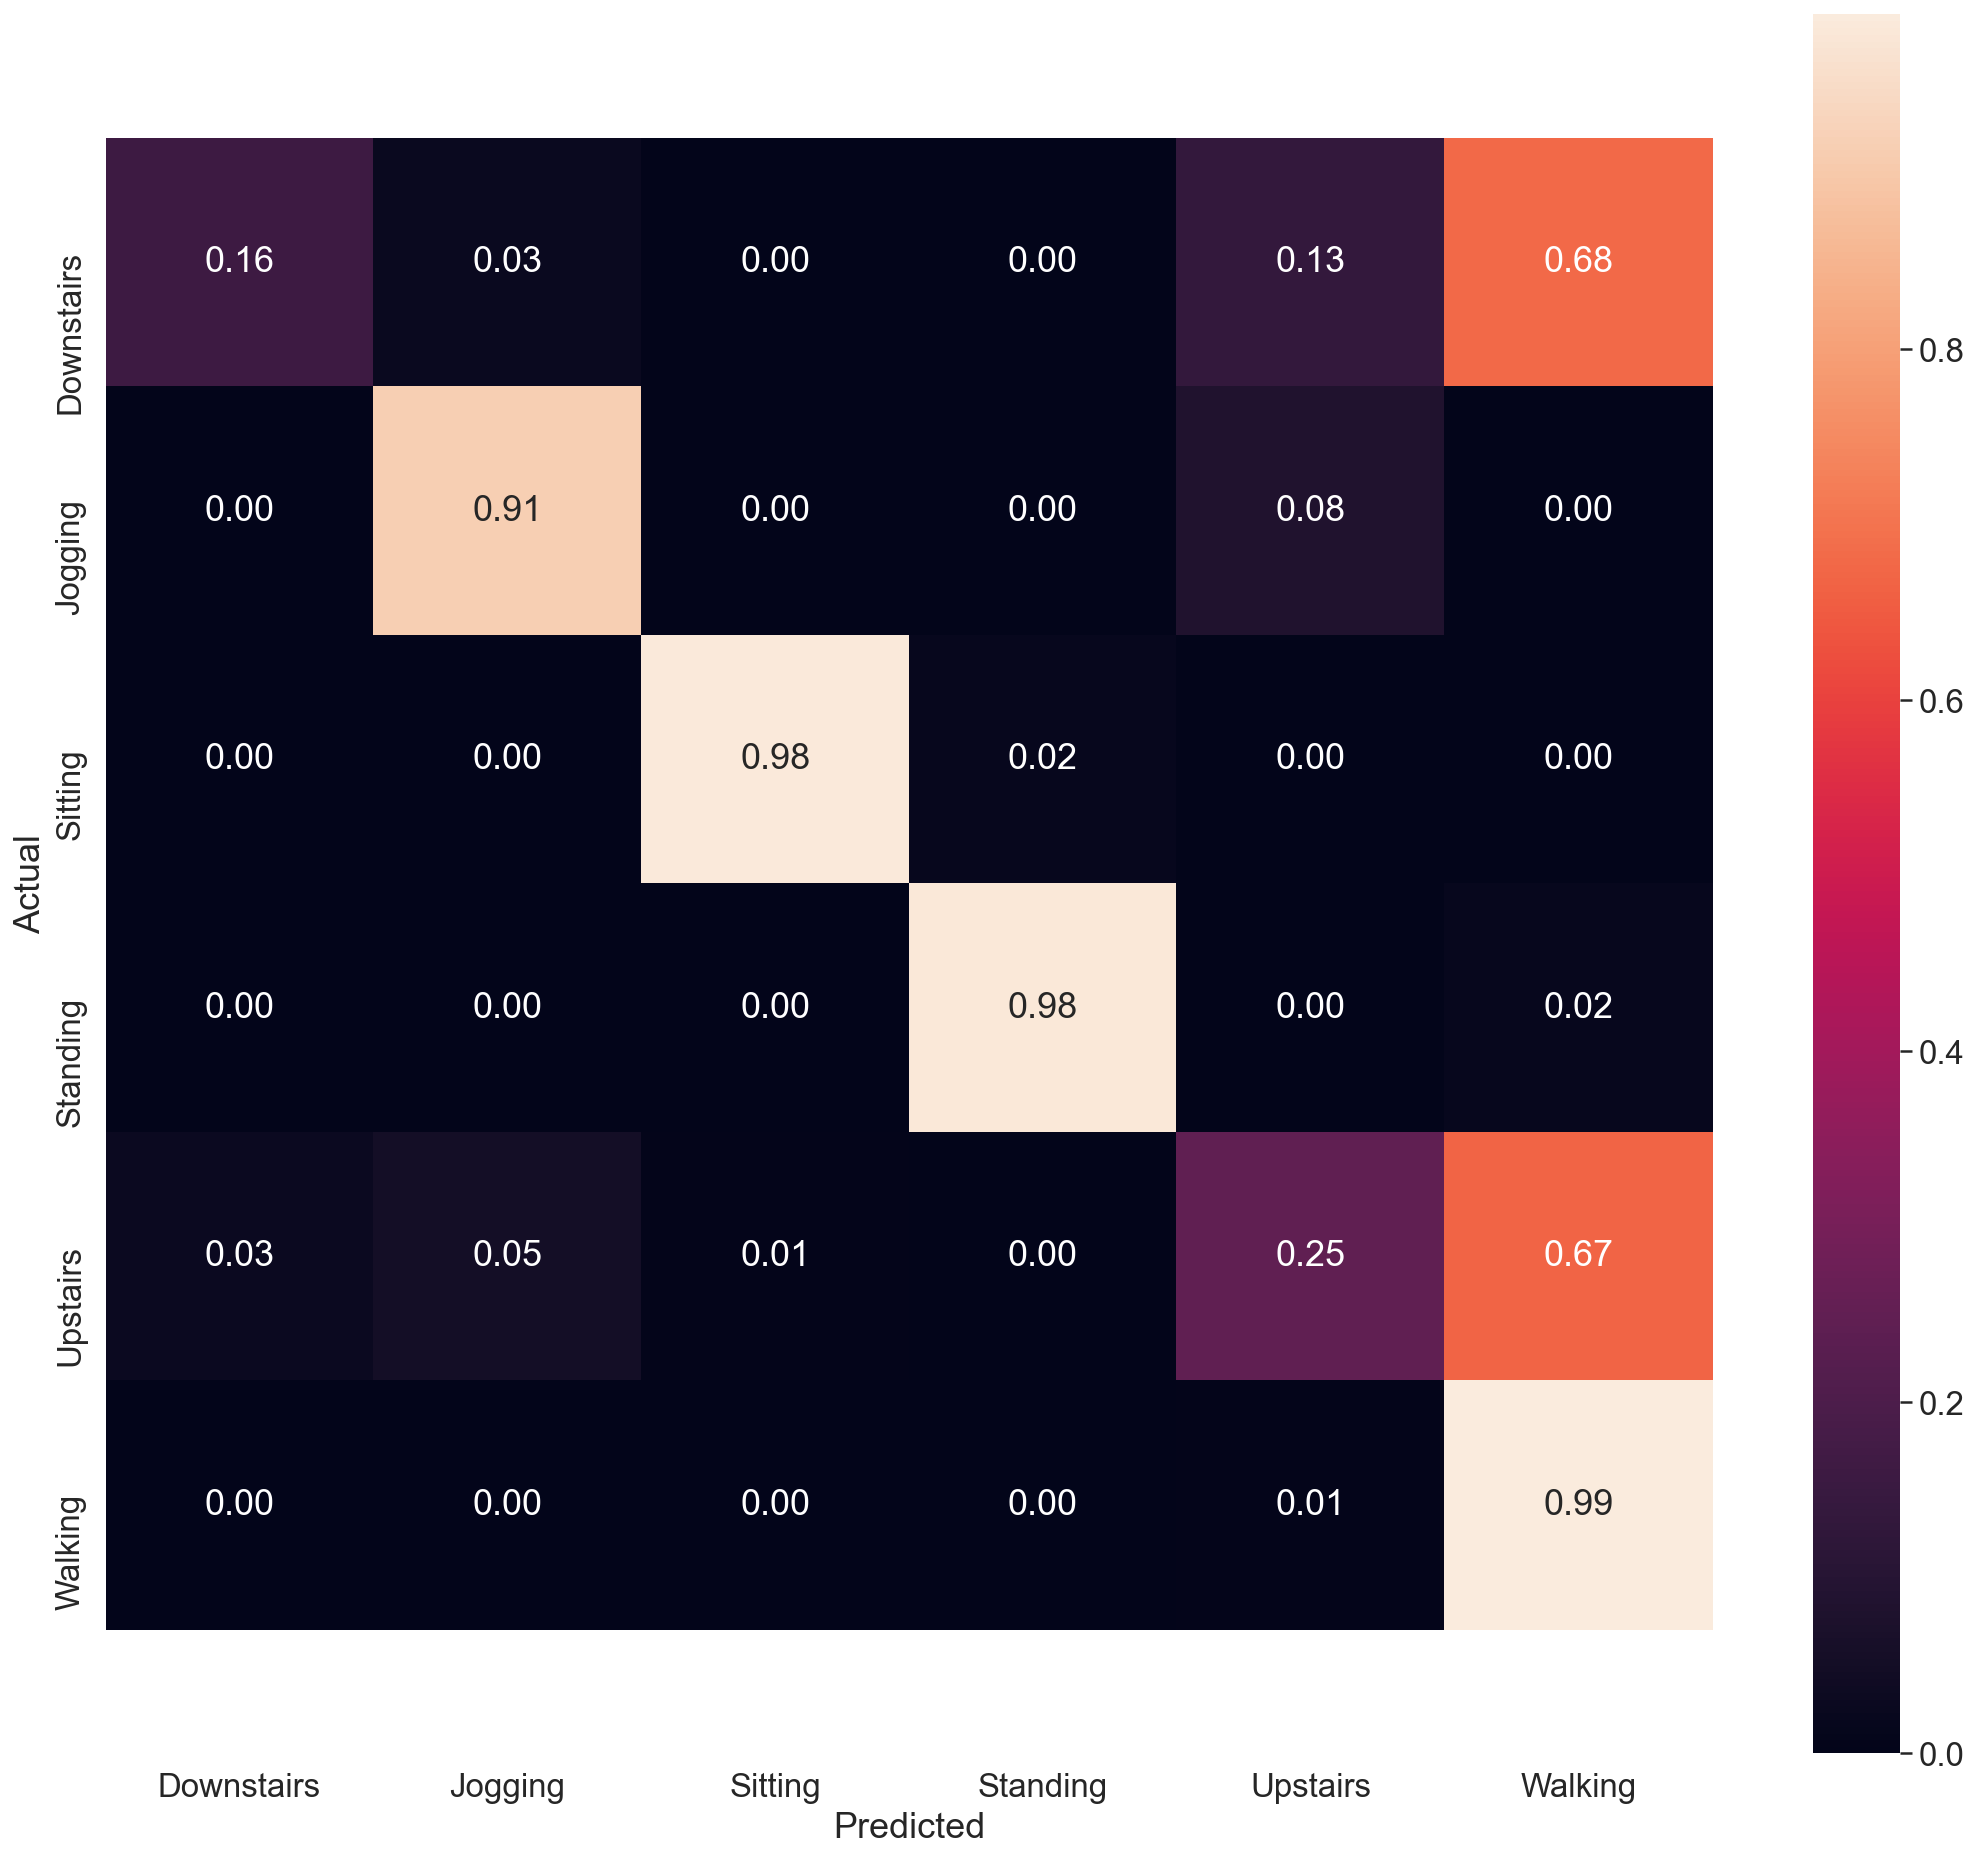

In [234]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

In [235]:
from sklearn.metrics import classification_report

print("             Results for Test Set\n\n" + 
      classification_report(enc.inverse_transform(y_pred),
                            enc.inverse_transform(y_test)))

             Results for Test Set

              precision    recall  f1-score   support

  Downstairs       0.16      0.75      0.26        24
     Jogging       0.91      0.97      0.94       384
     Sitting       0.98      0.99      0.99       123
    Standing       0.98      0.98      0.98       112
    Upstairs       0.25      0.45      0.32        95
     Walking       0.99      0.69      0.81       630

    accuracy                           0.80      1368
   macro avg       0.71      0.81      0.72      1368
weighted avg       0.90      0.80      0.84      1368



## Comparison to baseline models other approaches

The results above are at least comparable to other experimental results by [Jennifer R. Kwapisz et al 2010](https://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf) where their best reported model of an MLP achieved acc ~ 91%. With notablly better confusion matrix on our part. See tables below:

<img src="images/wisdm-2010-table2.png" height=40% width=40%>

<img src="images/wisdm-2010-table5.png" height=40% width=40%>

Another piece of work that is work comparing against is the analysis done by Jason Brownlee found [here](https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/)

The scope of that analysis was to evaluate deep learning methods for a similiar HAR dataset, namely the [Human Activity Recognition Using Smartphones Data Set, UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)

> The raw data is not available. Instead, a pre-processed version of the dataset was made available. The pre-processing steps included:

> Pre-processing accelerometer and gyroscope using noise filters.
Splitting data into fixed windows of 2.56 seconds (128 data points) with 50% overlap.Splitting of accelerometer data into gravitational (total) and body motion components.
Feature engineering was applied to the window data, and a copy of the data with these engineered features was made available.

> A number of time and frequency features commonly used in the field of human activity recognition were extracted from each window. The result was a 561 element vector of features.

> The dataset was split into train (70%) and test (30%) sets based on data for subjects, e.g. 21 subjects for train and nine for test.

> Experiment results with a support vector machine intended for use on a smartphone (e.g. fixed-point arithmetic) resulted in a predictive accuracy of 89% on the test dataset, achieving similar results as an unmodified SVM implementation.

Jason Brownlee was able to get results on the order of ~ 90% for:
- LSTM --> Accuracy: 89.722% (+/-1.371)
- CNN+LSTM --> Accuracy: 90.689% (+/-1.051)
- ConvLSTM --> Accuracy: 90.801% (+/-0.886)

It is felt that with further training and better hyperparameter optimisation, better can be achieved, but it has been kept in mind that the cope of this analysis is proof of concept.

As such, we will move on to exploring the updated version of **WISDM** released recently.

## WISDM-2019

In late 2019, an [updated **WISDM** dataset](https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+) was release which included 18 categories with many more observations. It is a big imporovement on the previous dataset, with balanced class distributions shown in table 4 of the [paper](https://archive.ics.uci.edu/ml/machine-learning-databases/00507/WISDM-dataset-description.pdf) and visualised below:

In [236]:
import os
import statistics
import csv
import itertools
from tensorflow import keras

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [237]:
with open(r"../data/wisdm-dataset/activity_key.txt") as f:
    activity_list = f.read().split("\n")

In [238]:
activity_list

['walking = A',
 'jogging = B',
 'stairs = C',
 'sitting = D',
 'standing = E',
 'typing = F',
 'teeth = G',
 'soup = H',
 'chips = I',
 'pasta = J',
 'drinking = K',
 'sandwich = L',
 'kicking = M',
 'catch = O',
 'dribbling = P',
 'writing = Q',
 'clapping = R',
 'folding = S',
 '',
 '']

In [239]:
activity_map = {}
for element in activity_list:
    split = element.split(" = ")
    if len(split) < 2:
        continue
    activity_map[split[1]] = split[0]

In [240]:
activity_map.values()

dict_values(['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing', 'teeth', 'soup', 'chips', 'pasta', 'drinking', 'sandwich', 'kicking', 'catch', 'dribbling', 'writing', 'clapping', 'folding'])

As this is quite a large dataset, to save pre-processing time, I have taken "ready-made" dataframe files from: https://github.com/LACoderDeBH/CS230_HAR_WISDM

The work presented there and published by [Susana Benavidez et al 2019](http://cs230.stanford.edu/projects_fall_2019/reports/26221049.pdf) is what will be used to compare results with laatest attempts at applying deep learning methods to the updated **WISDM** dataset

In [241]:
import pickle

with open(r"../data/wisdm-dataset/phone.df", "rb") as input_file:
    phone = pickle.load(input_file)
    
with open(r"../data/wisdm-dataset/watch.df", "rb") as input_file:
    watch = pickle.load(input_file)

### Phone Data

In [242]:
phone.head()

,participant,activity,t,phone_accel_x,phone_accel_y,phone_accel_z,phone_gyro_x,phone_gyro_y,phone_gyro_z
0,1631,D,1551056925666819,2.415741,8.470810,3.941772,-0.334335,-0.170898,0.175385
1,1631,D,1551056976020823,2.387329,7.766327,2.867630,-0.452133,0.375458,0.078552
2,1631,D,1551057026374827,8.274826,6.988464,1.375259,-0.982391,-0.198990,0.801300
3,1631,D,1551057076728831,4.721298,9.469116,5.418472,-0.643814,1.017700,-0.887161
4,1631,D,1551057127082835,1.159759,7.087219,3.427551,-1.286362,1.523544,-1.482986


In [243]:
phone.shape

(4780251, 9)

[[Text(0, 0, 'walking'),
  Text(1, 0, 'jogging'),
  Text(2, 0, 'stairs'),
  Text(3, 0, 'sitting'),
  Text(4, 0, 'standing'),
  Text(5, 0, 'typing'),
  Text(6, 0, 'teeth'),
  Text(7, 0, 'soup'),
  Text(8, 0, 'chips'),
  Text(9, 0, 'pasta'),
  Text(10, 0, 'drinking'),
  Text(11, 0, 'sandwich'),
  Text(12, 0, 'kicking'),
  Text(13, 0, 'catch'),
  Text(14, 0, 'dribbling'),
  Text(15, 0, 'writing'),
  Text(16, 0, 'clapping'),
  Text(17, 0, 'folding')]]

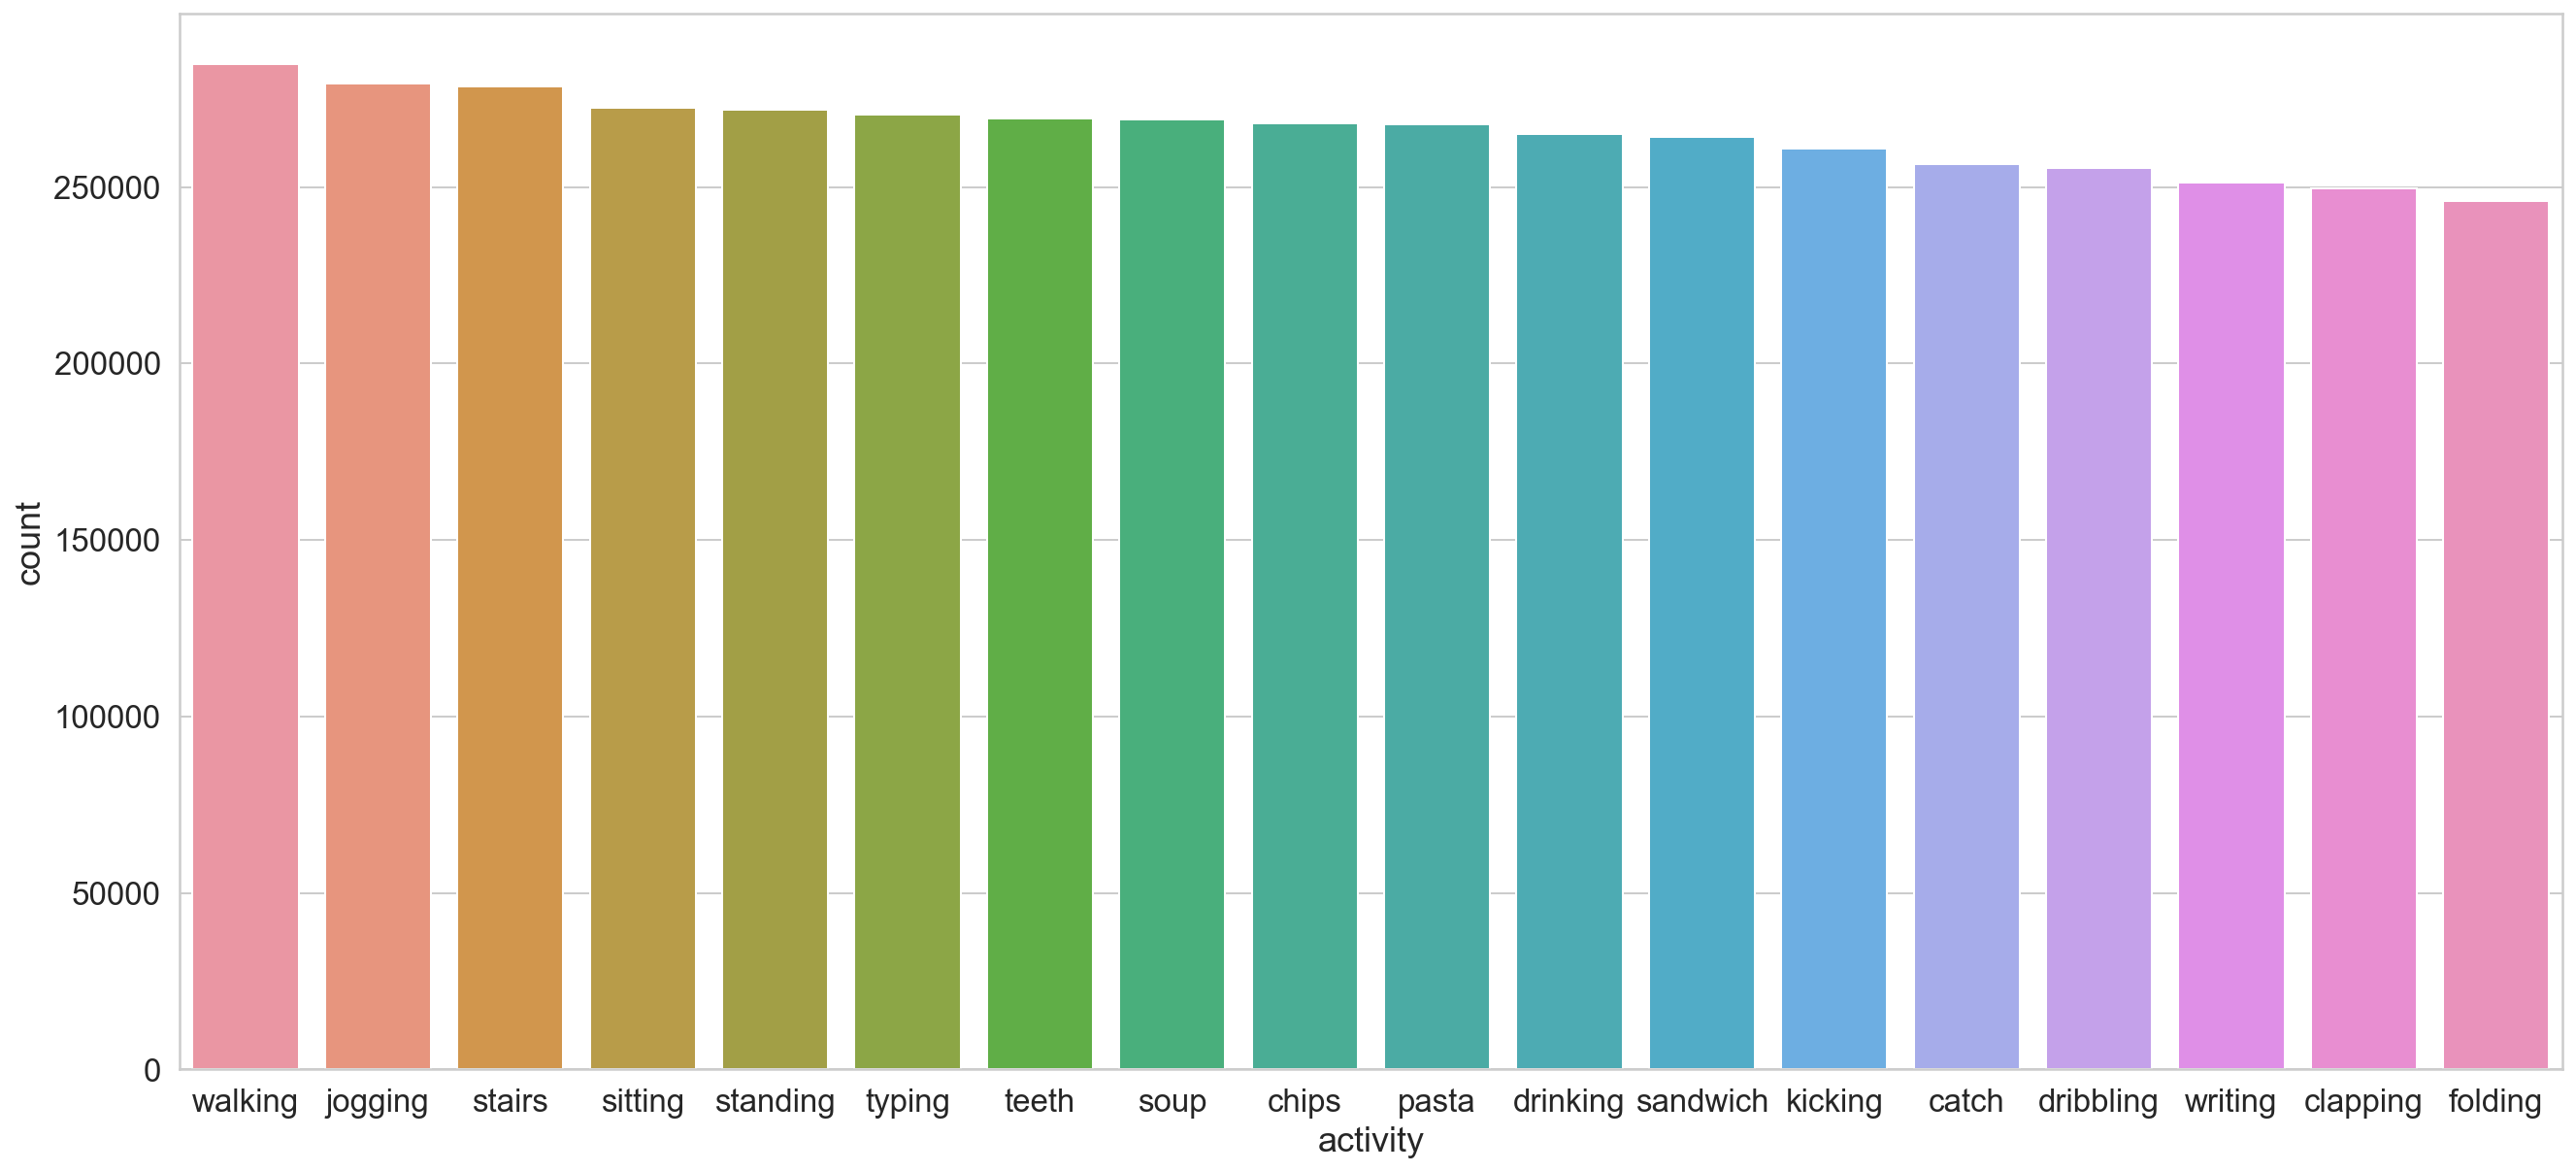

In [244]:
cp = sns.countplot(x = 'activity',
              data = phone,
              order = phone.activity.value_counts().index);
cp.set(xticklabels=activity_map.values())

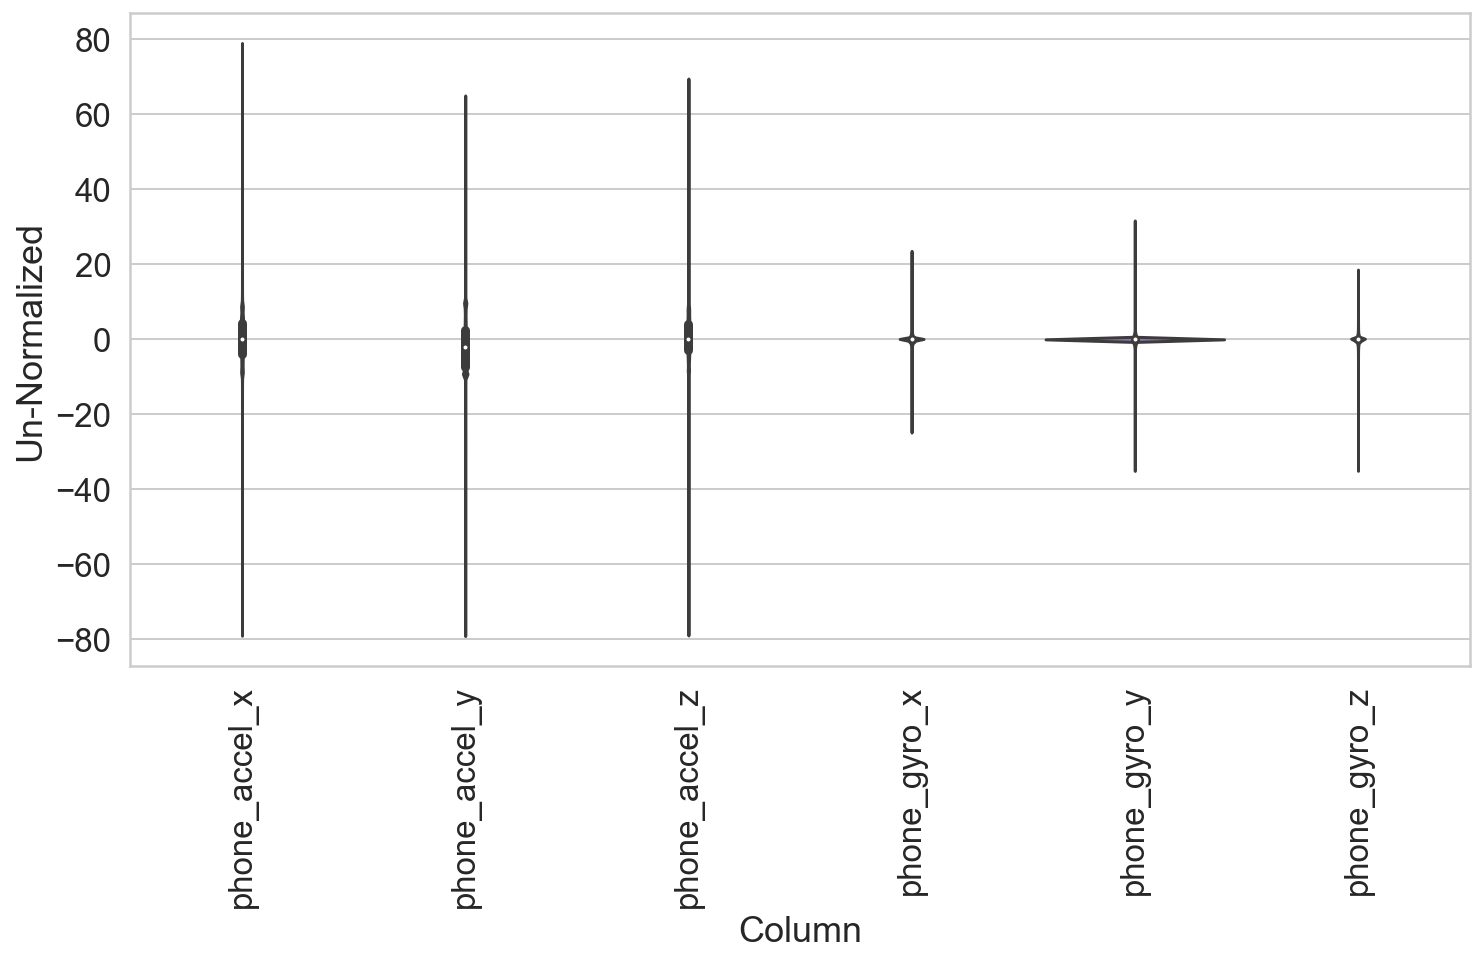

In [245]:
df_dist = phone[['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']].melt(var_name='Column', value_name='Un-Normalized')

df_dist.dropna(inplace=True)
df_dist = df_dist.astype({'Un-Normalized': 'float'})

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Un-Normalized', data=df_dist)
_ = ax.set_xticklabels(phone[['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']].keys(), rotation=90)

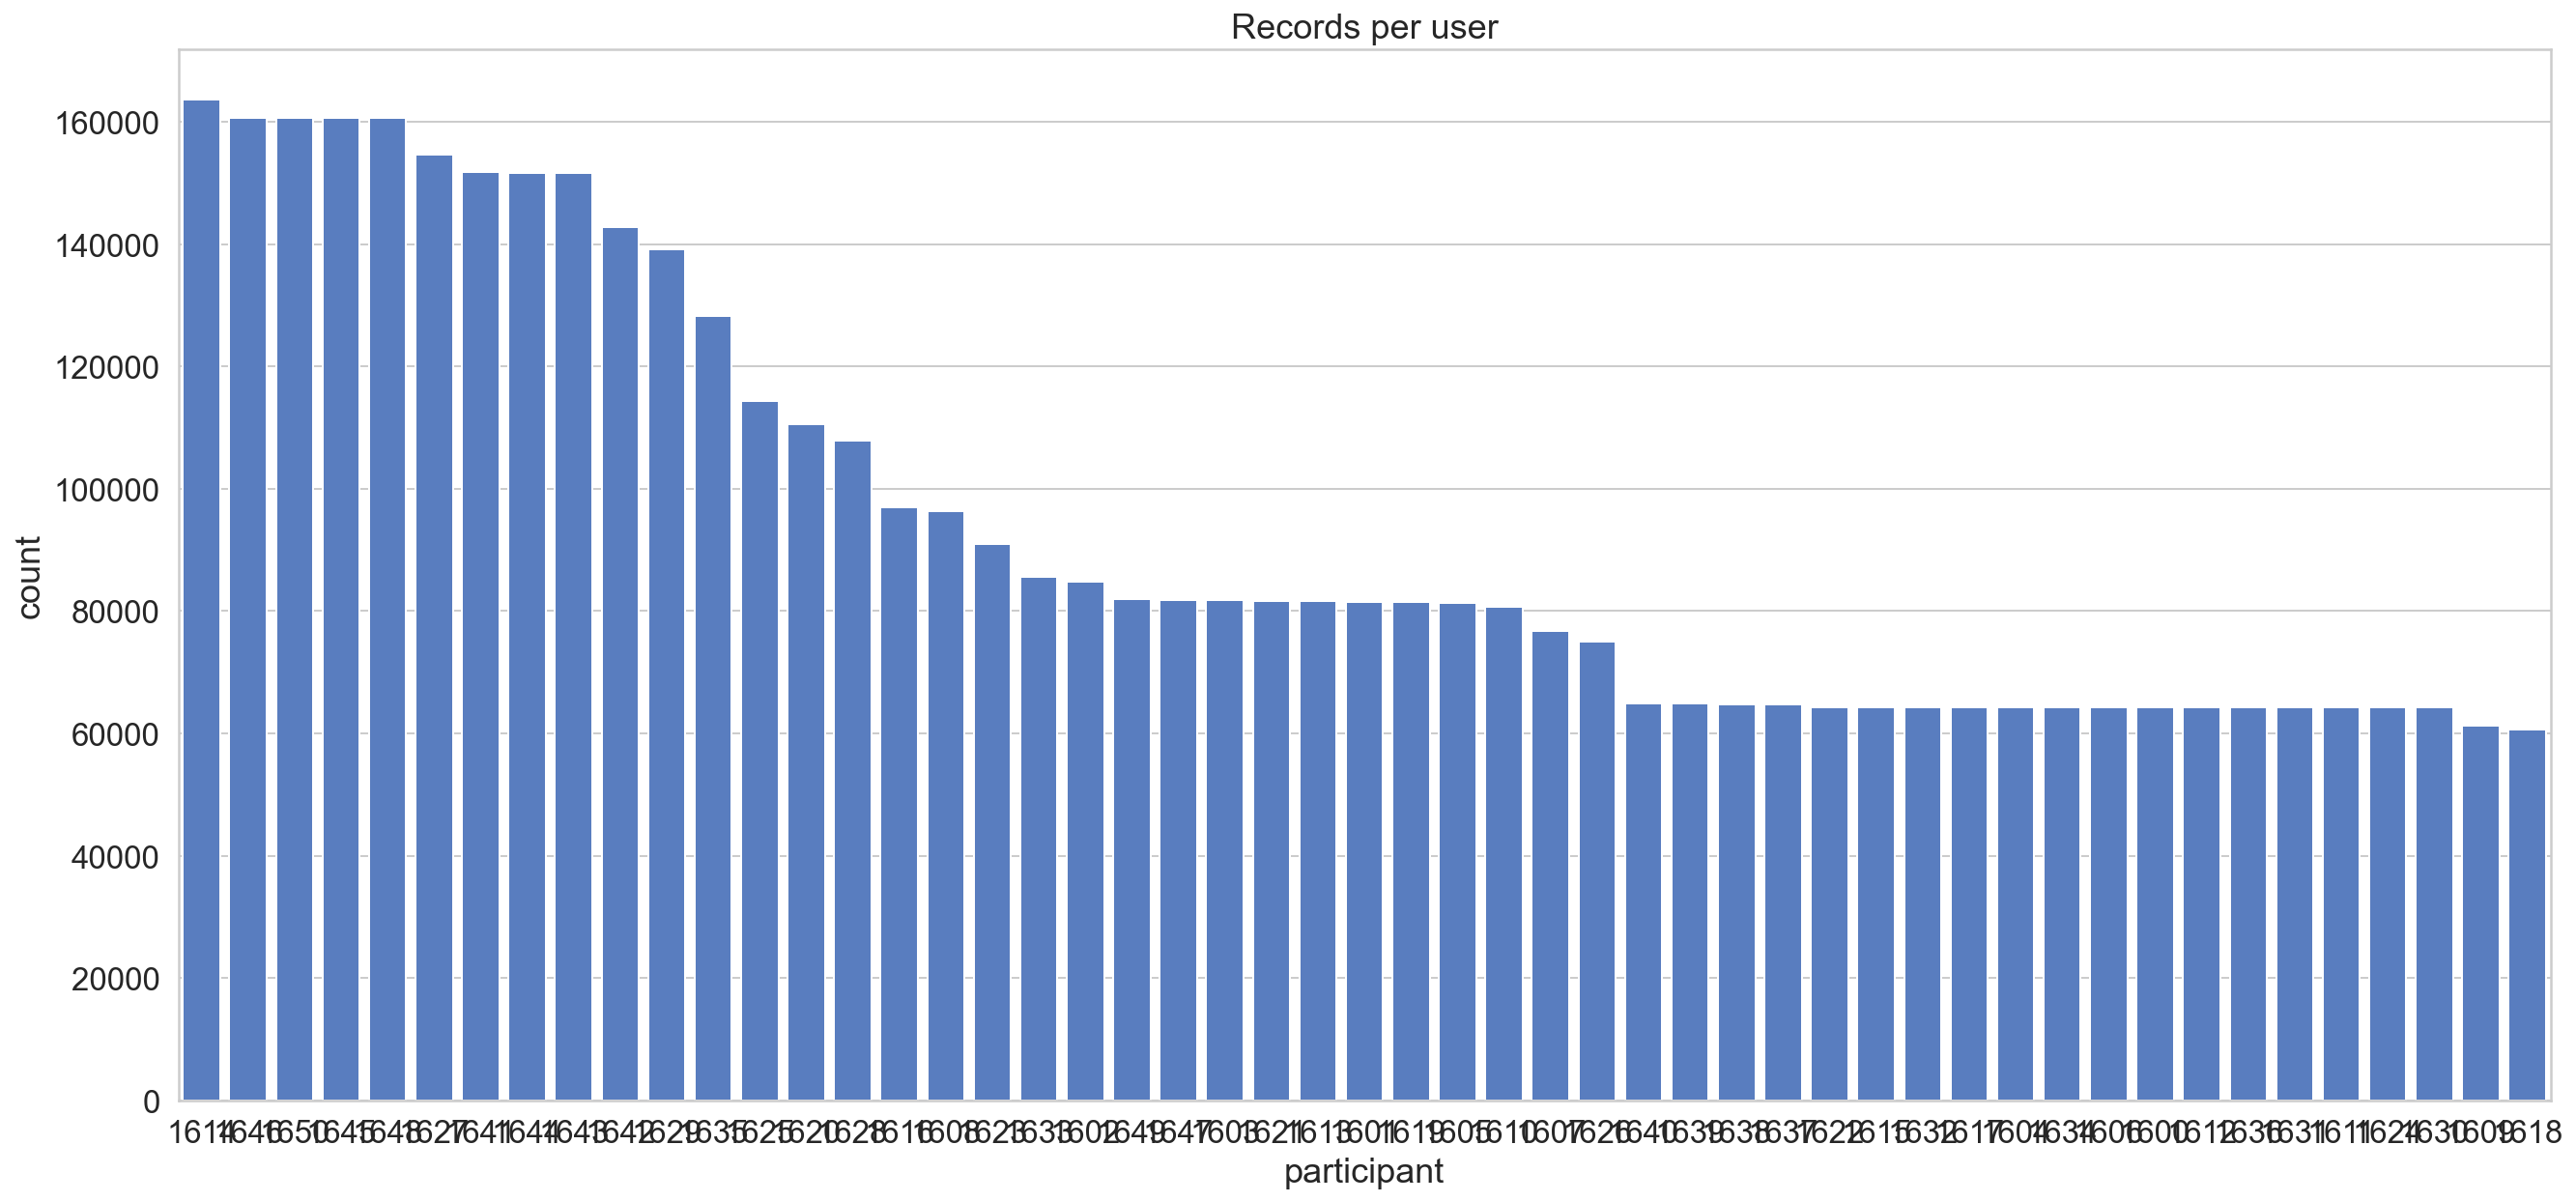

In [246]:
sns.countplot(x = 'participant',
              data = phone,
              palette=[sns.color_palette()[0]],
              order = phone.participant.value_counts().index);
plt.title("Records per user");

In [247]:
def train_val_test_split(df, cols):
    
    features = df[cols]
    column_indices = {name: i for i, name in enumerate(features.columns)}

    n = len(df)
    df_train = df[0:int(n*0.8)].copy()
    df_val = df[int(n*0.8):int(n*0.95)].copy()
    df_test = df[int(n*0.95):].copy()

    num_features = features.shape[1]
    
    return df_train, df_val, df_test, num_features

In [248]:
cols = ['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']

In [249]:
train_df, val_df, test_df, num_features = train_val_test_split(phone, cols)

In [250]:
num_features

6

In [251]:
train_df.head()

,participant,activity,t,phone_accel_x,phone_accel_y,phone_accel_z,phone_gyro_x,phone_gyro_y,phone_gyro_z
0,1631,D,1551056925666819,2.415741,8.470810,3.941772,-0.334335,-0.170898,0.175385
1,1631,D,1551056976020823,2.387329,7.766327,2.867630,-0.452133,0.375458,0.078552
2,1631,D,1551057026374827,8.274826,6.988464,1.375259,-0.982391,-0.198990,0.801300
3,1631,D,1551057076728831,4.721298,9.469116,5.418472,-0.643814,1.017700,-0.887161
4,1631,D,1551057127082835,1.159759,7.087219,3.427551,-1.286362,1.523544,-1.482986


In [252]:
cols = ['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']

In [253]:
def plot_activity(activity, df, cols):
    data = df[df['activity'] == activity][cols][:400]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

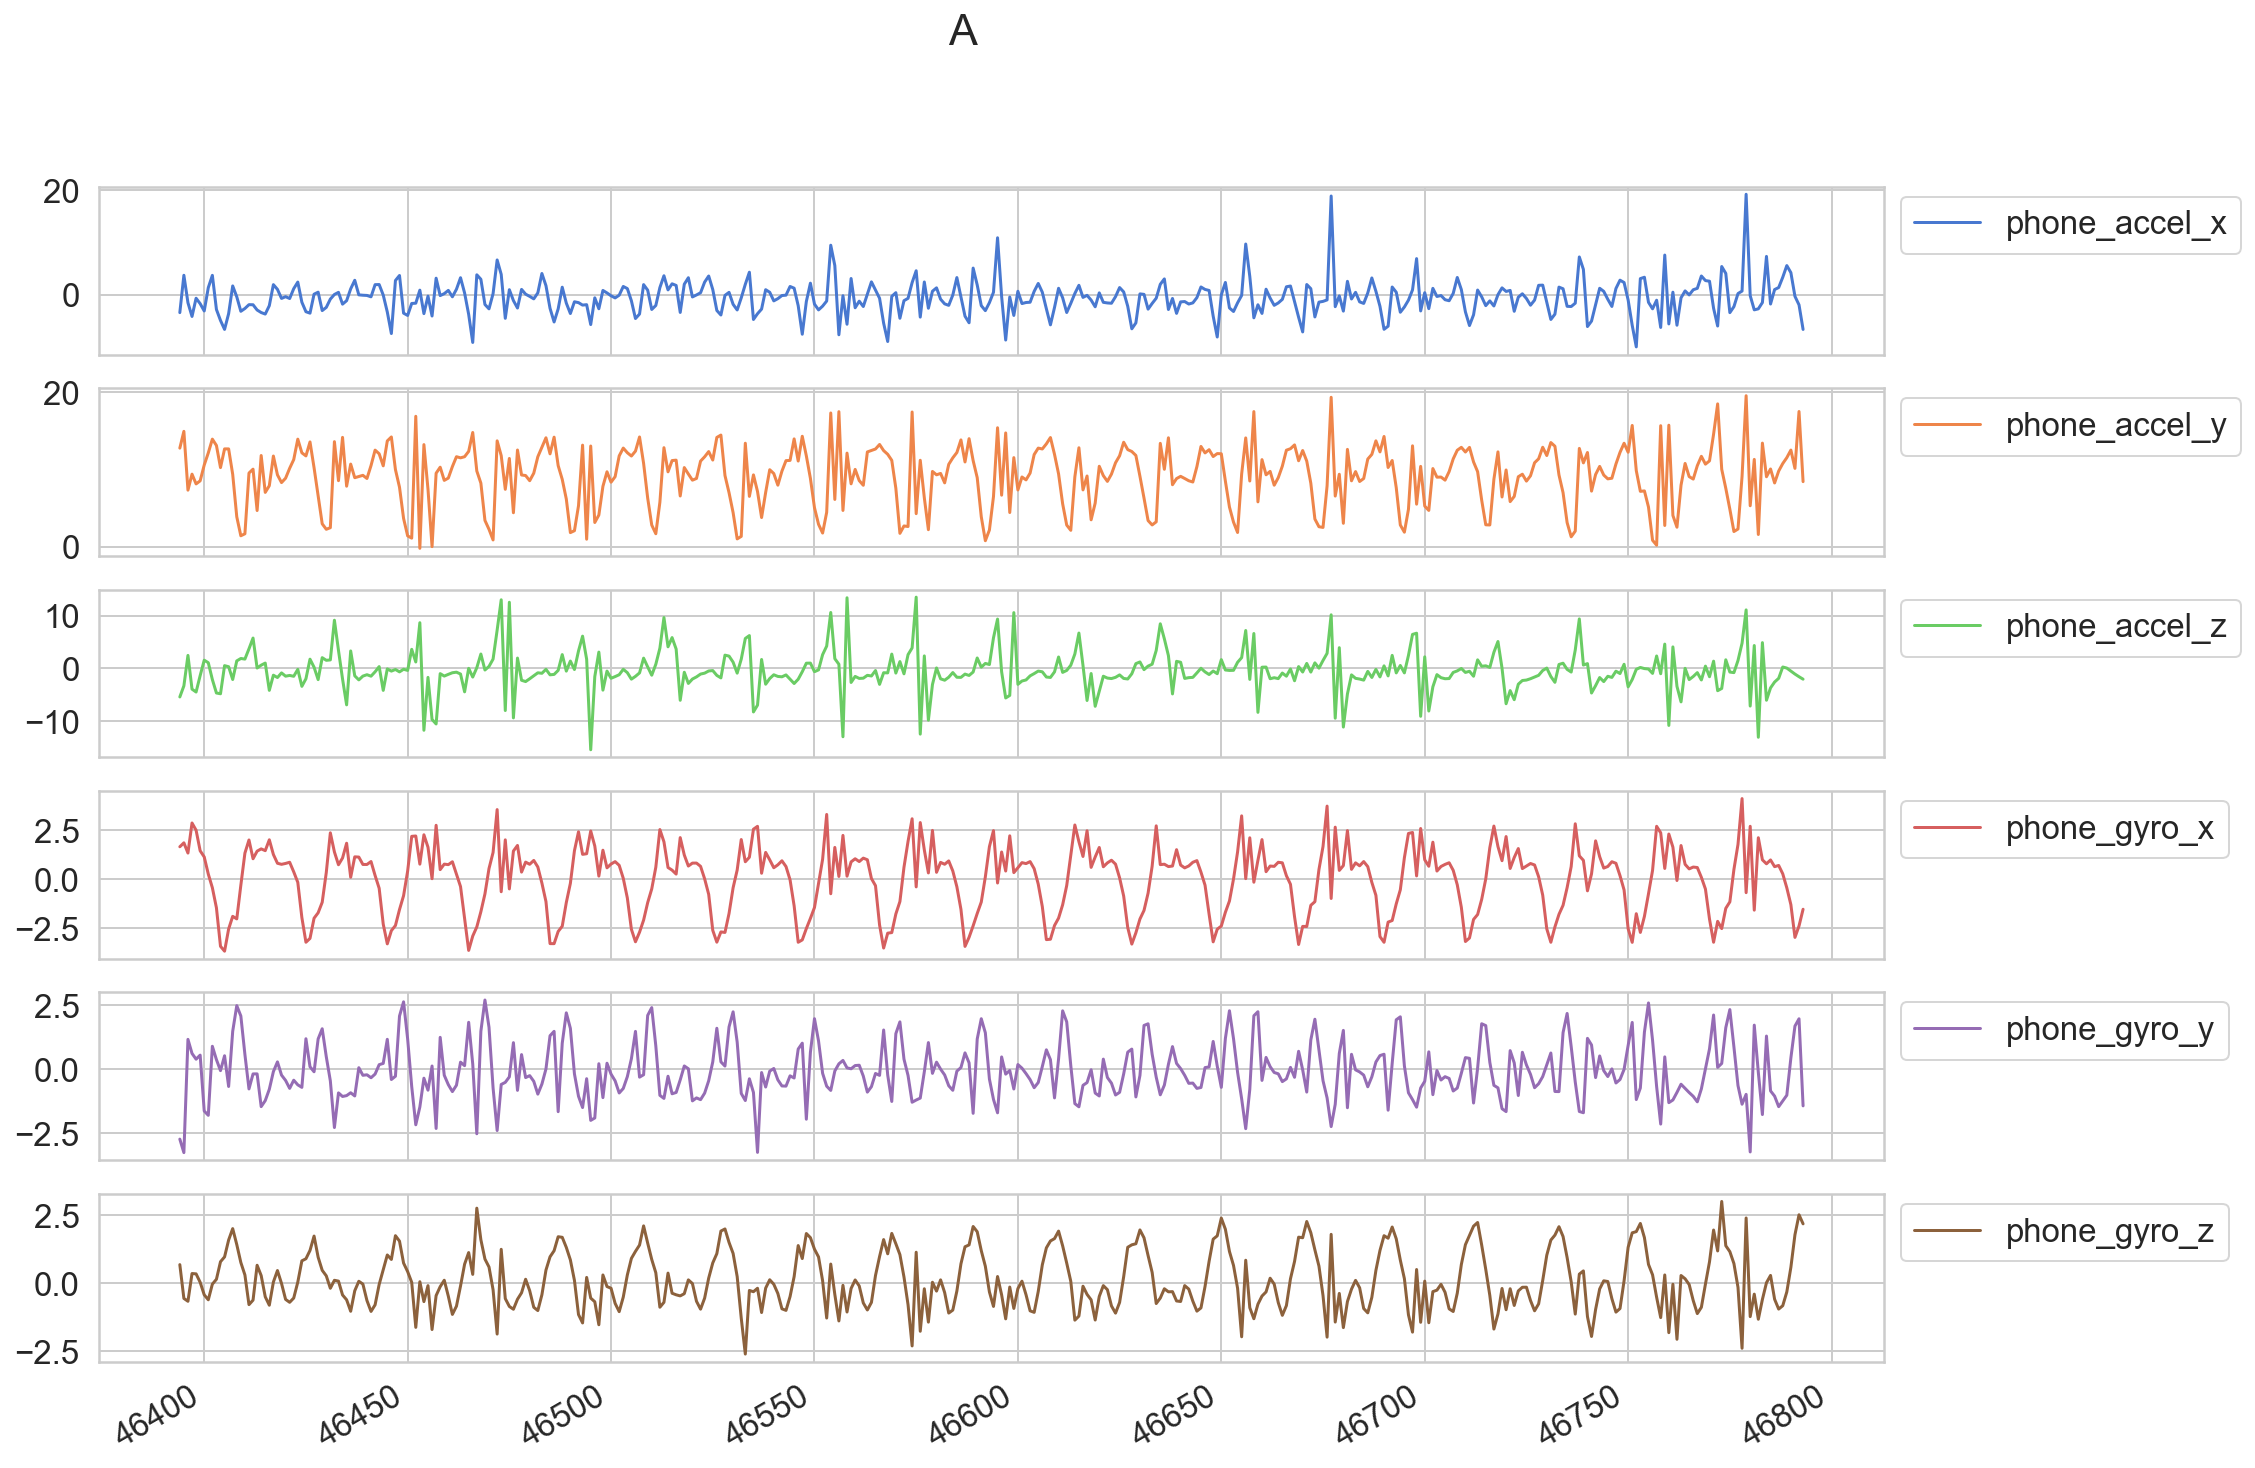

In [254]:
plot_activity("A", train_df, cols);

In [255]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']

scaler = RobustScaler()

scaler = scaler.fit(train_df[scale_columns])

train_df.loc[:, scale_columns] = scaler.transform(train_df[scale_columns].to_numpy())
val_df.loc[:, scale_columns] = scaler.transform(val_df[scale_columns].to_numpy())
test_df.loc[:, scale_columns] = scaler.transform(test_df[scale_columns].to_numpy())

In [256]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 100
STEP = 40

X_train, y_train = create_dataset(
    train_df[['phone_accel_x', 'phone_accel_y', 'phone_accel_z']], 
    train_df.activity, 
    TIME_STEPS, 
    STEP
)

X_val, y_val = create_dataset(
    val_df[['phone_accel_x', 'phone_accel_y', 'phone_accel_z']], 
    val_df.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    test_df[['phone_accel_x', 'phone_accel_y', 'phone_accel_z']], 
    test_df.activity, 
    TIME_STEPS, 
    STEP
)

In [257]:
print(X_train.shape, y_train.shape)

(95603, 100, 3) (95603, 1)


In [258]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)

In [259]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(95603, 100, 3) (95603, 18)
(17924, 100, 3) (17924, 18)
(5973, 100, 3) (5973, 18)


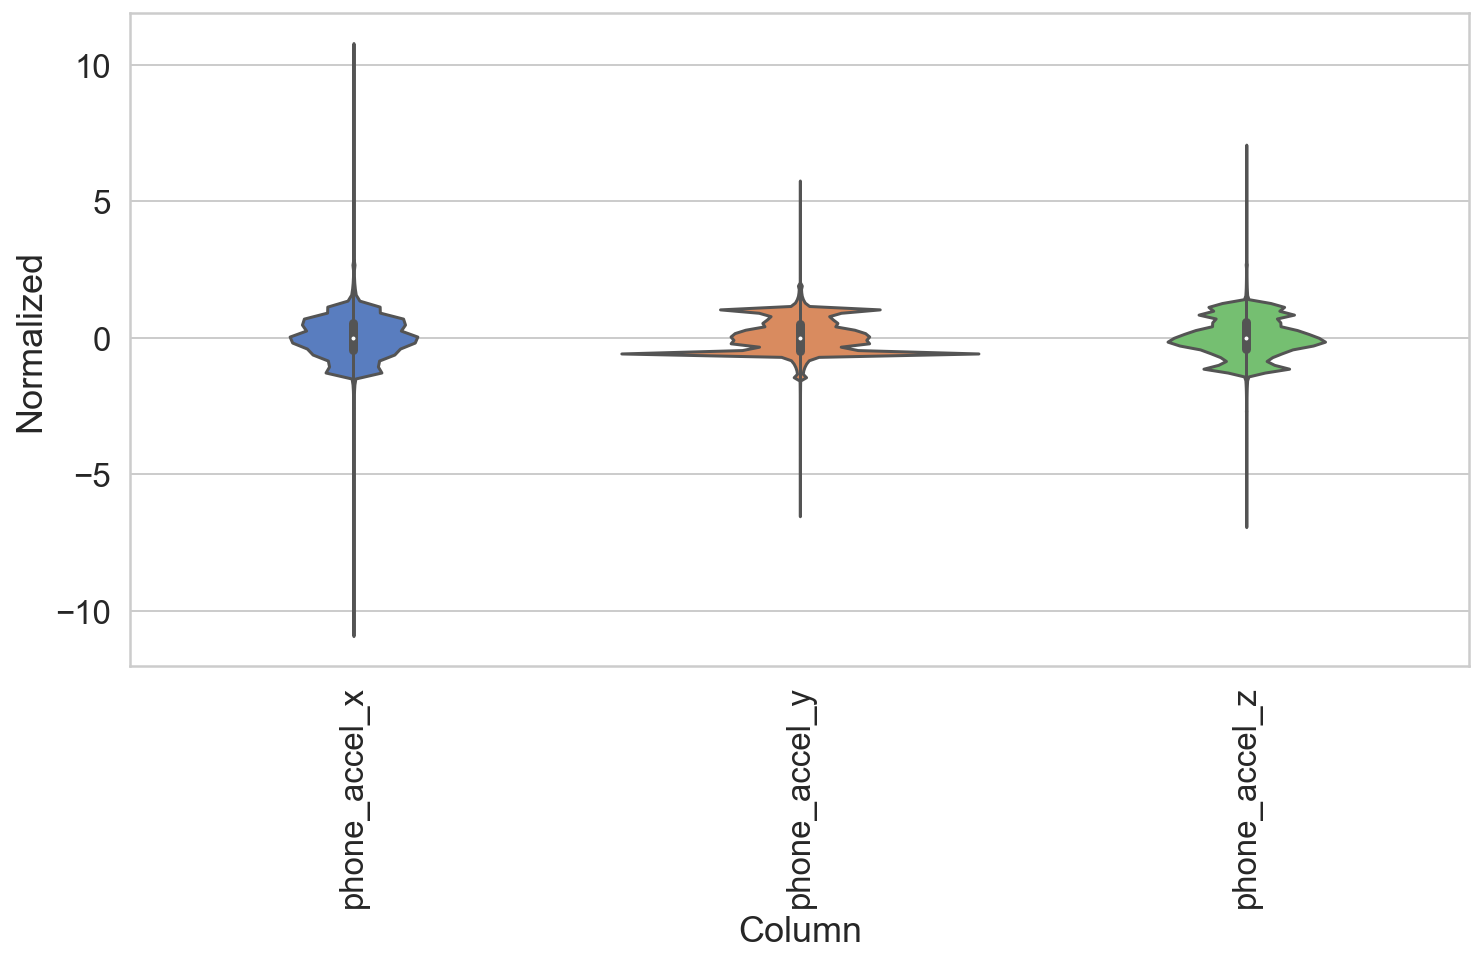

In [260]:
df_dist = train_df[['phone_accel_x', 'phone_accel_y', 'phone_accel_z']].melt(var_name='Column', value_name='Normalized')

df_dist.dropna(inplace=True)
df_dist = df_dist.astype({'Normalized': 'float'})

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_dist)
_ = ax.set_xticklabels(phone[['phone_accel_x', 'phone_accel_y', 'phone_accel_z']].keys(), rotation=90)

In [261]:
input_shape = X_train.shape 
input_shape[1:] # (TIMESTEPS, num_features) 

(100, 3)

In [264]:
model = keras.Sequential()

# model.add(layers.Dense(units=128))

# Old API
# model.add(layers.Convolution1D(filters=128, kernel_size=16, activation='relu'))
# New Keras API
# model.add(layers.Conv1D(filters=128, kernel_size=16, activation='relu', input_shape=input_shape[1:]))

# Inspired by this line: Note that a TimeDistributed(Dense(n)) layer is equivalent to a Conv1D(n, filter_size=1) layer. 
# Moving kernel_size from 16 to 1
# Each time-step becomes a 32-vector, where one can think of a window of 200 time-steps being equivulent 
# to a sentence in NLP land
model.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=input_shape[1:]))

model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(18, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [265]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val)
)

Epoch 1/20
2988/2988 [==============================] - 71s 24ms/step - loss: 2.2008 - acc: 0.2375 - val_loss: 2.3265 - val_acc: 0.1954
Epoch 2/20
2988/2988 [==============================] - 71s 24ms/step - loss: 1.9173 - acc: 0.3228 - val_loss: 2.5058 - val_acc: 0.2017
Epoch 3/20
2988/2988 [==============================] - 74s 25ms/step - loss: 1.8324 - acc: 0.3505 - val_loss: 2.5943 - val_acc: 0.2282
Epoch 4/20
2988/2988 [==============================] - 78s 26ms/step - loss: 1.7772 - acc: 0.3717 - val_loss: 2.7699 - val_acc: 0.2170
Epoch 5/20
2988/2988 [==============================] - 91s 30ms/step - loss: 1.7360 - acc: 0.3866 - val_loss: 2.8767 - val_acc: 0.2183
Epoch 6/20
2988/2988 [==============================] - 92s 31ms/step - loss: 1.7004 - acc: 0.3994 - val_loss: 2.9838 - val_acc: 0.2188
Epoch 7/20
2988/2988 [==============================] - 90s 30ms/step - loss: 1.6717 - acc: 0.4082 - val_loss: 2.9822 - val_acc: 0.1927
Epoch 8/20
2988/2988 [==========================

In [266]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 100, 32)           128       
_________________________________________________________________
transformer_block_16 (Transf (None, 100, 32)           6464      
_________________________________________________________________
global_average_pooling1d_15  (None, 32)                0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 20)                660       
_________________________________________________________________
dropout_65 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 18)              

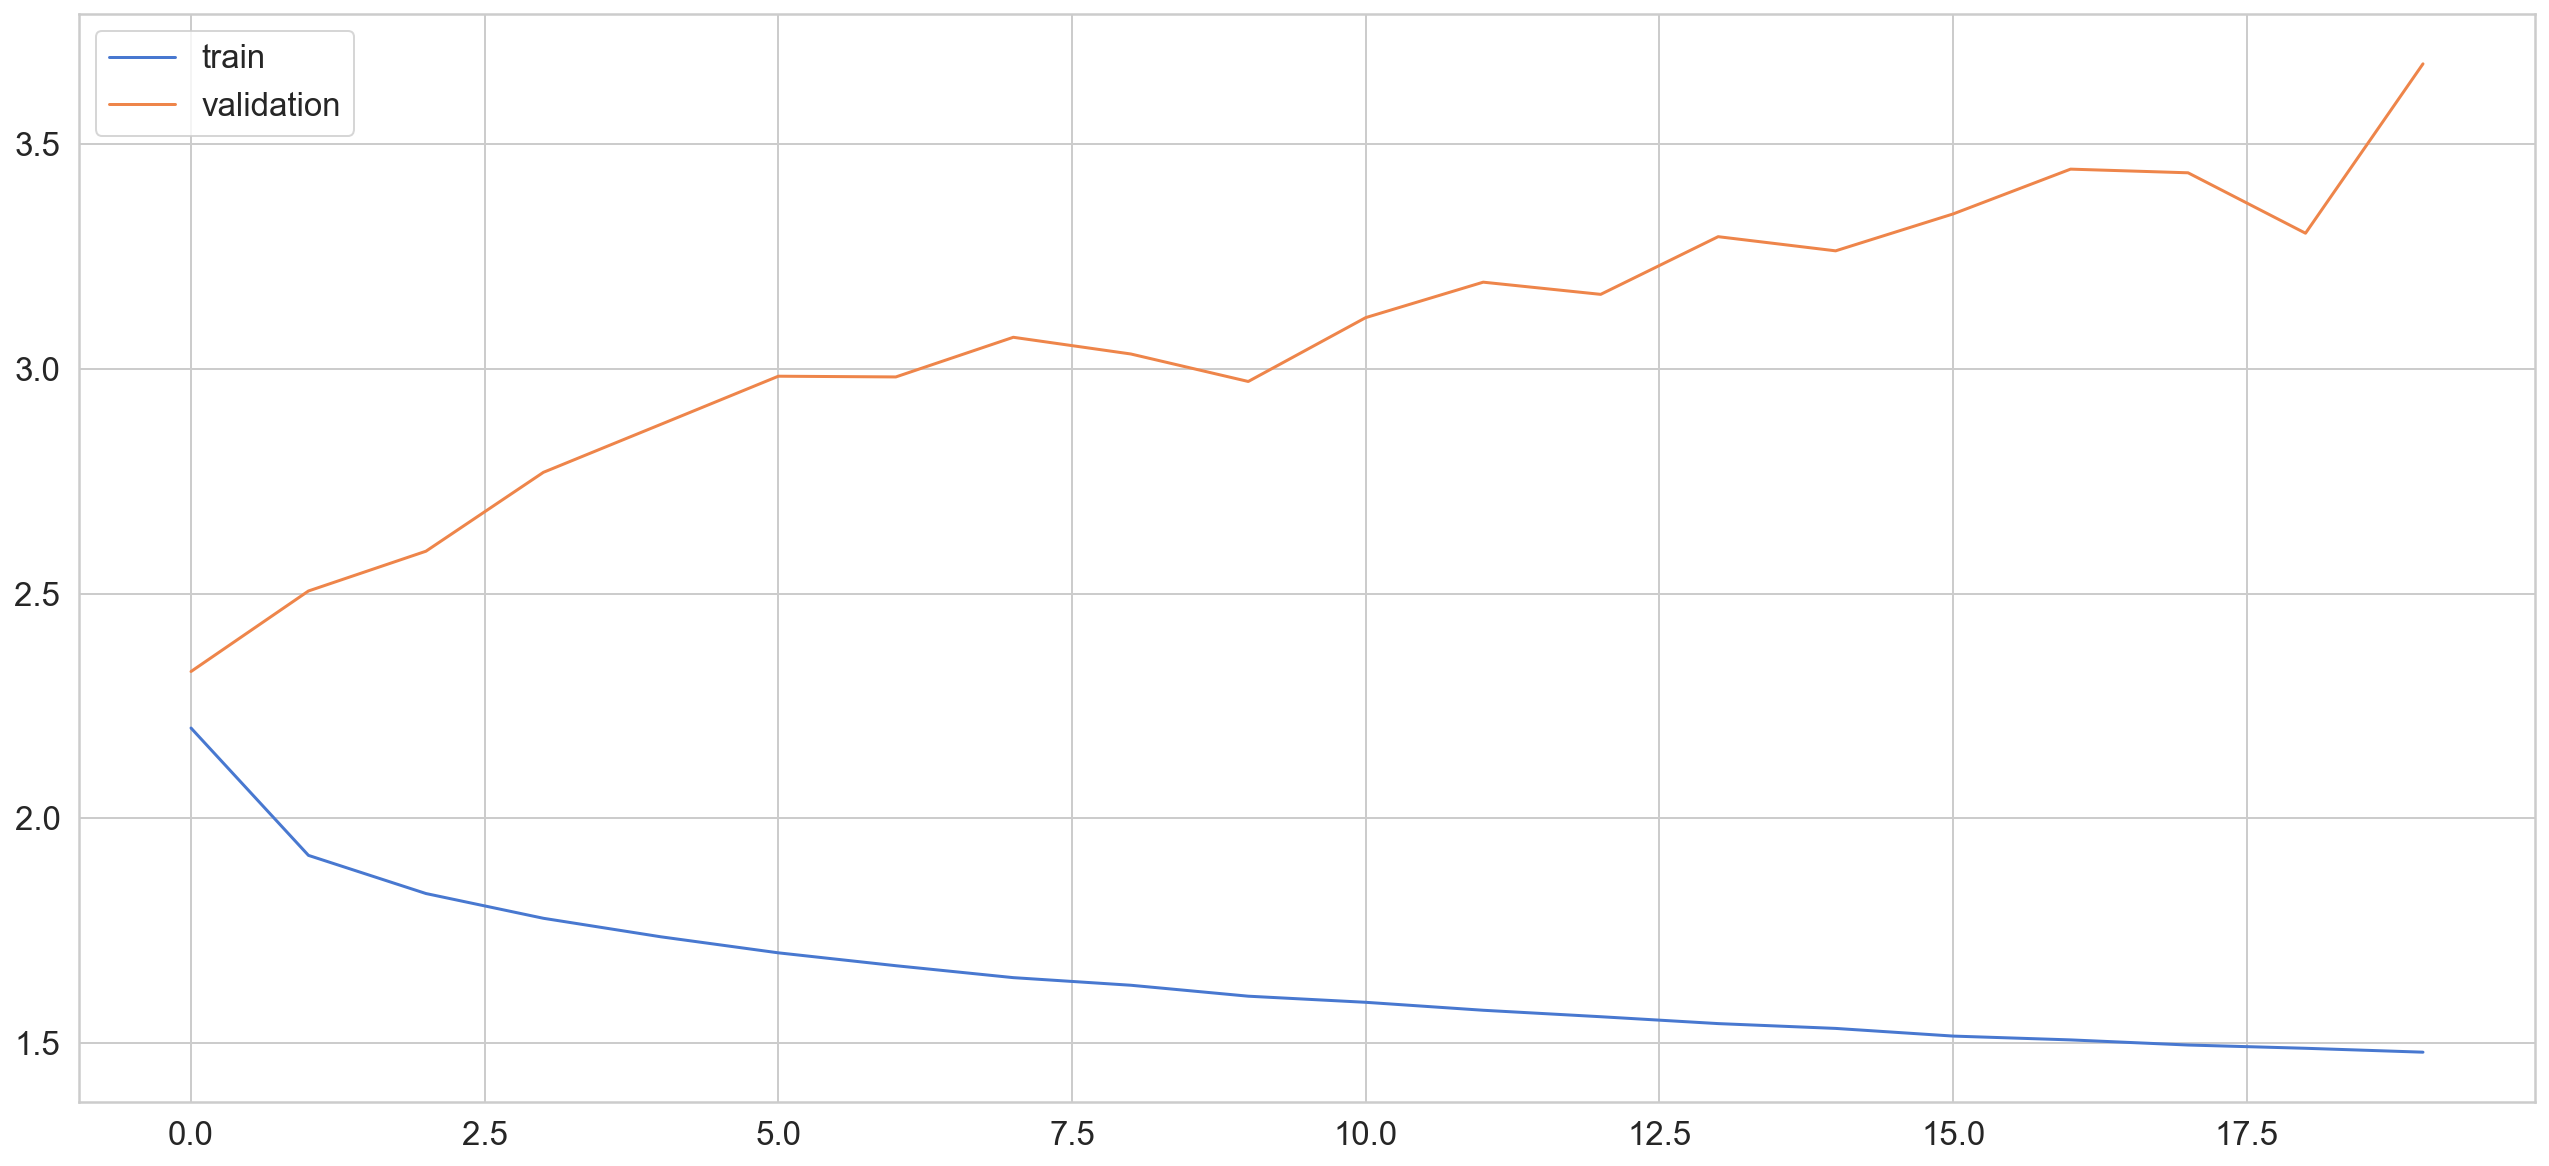

In [267]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

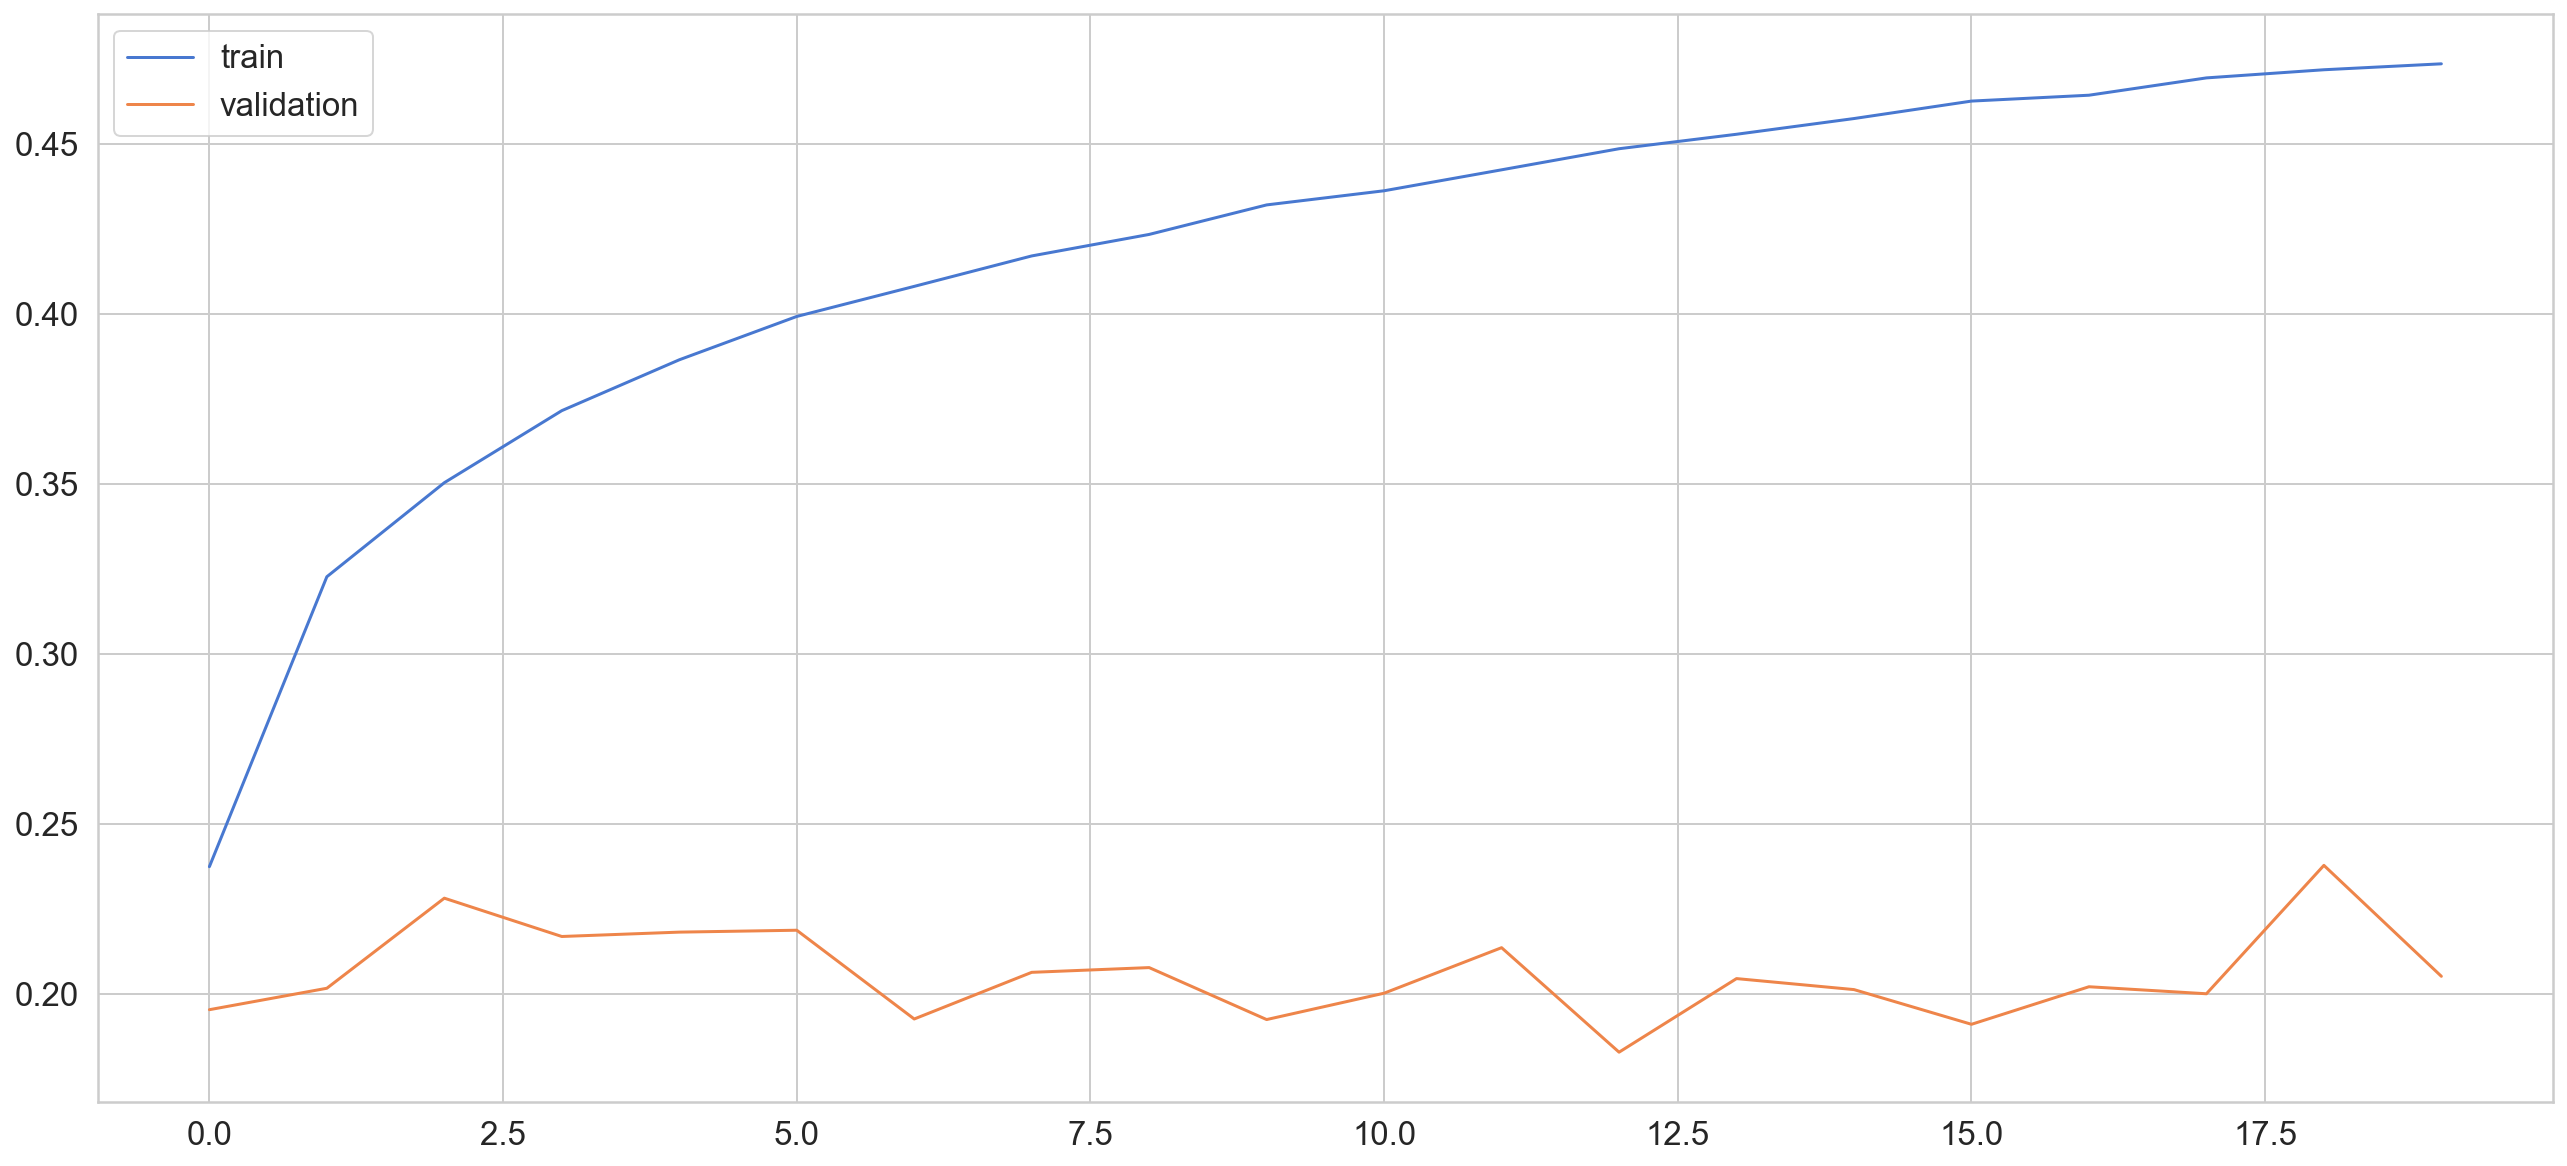

In [268]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend();

In [269]:
model.evaluate(X_test, y_test)

187/187 [==============================] - 2s 8ms/step - loss: 3.3571 - acc: 0.2456


[3.357097864151001, 0.2456052303314209]

In [270]:
y_pred = model.predict(X_test)

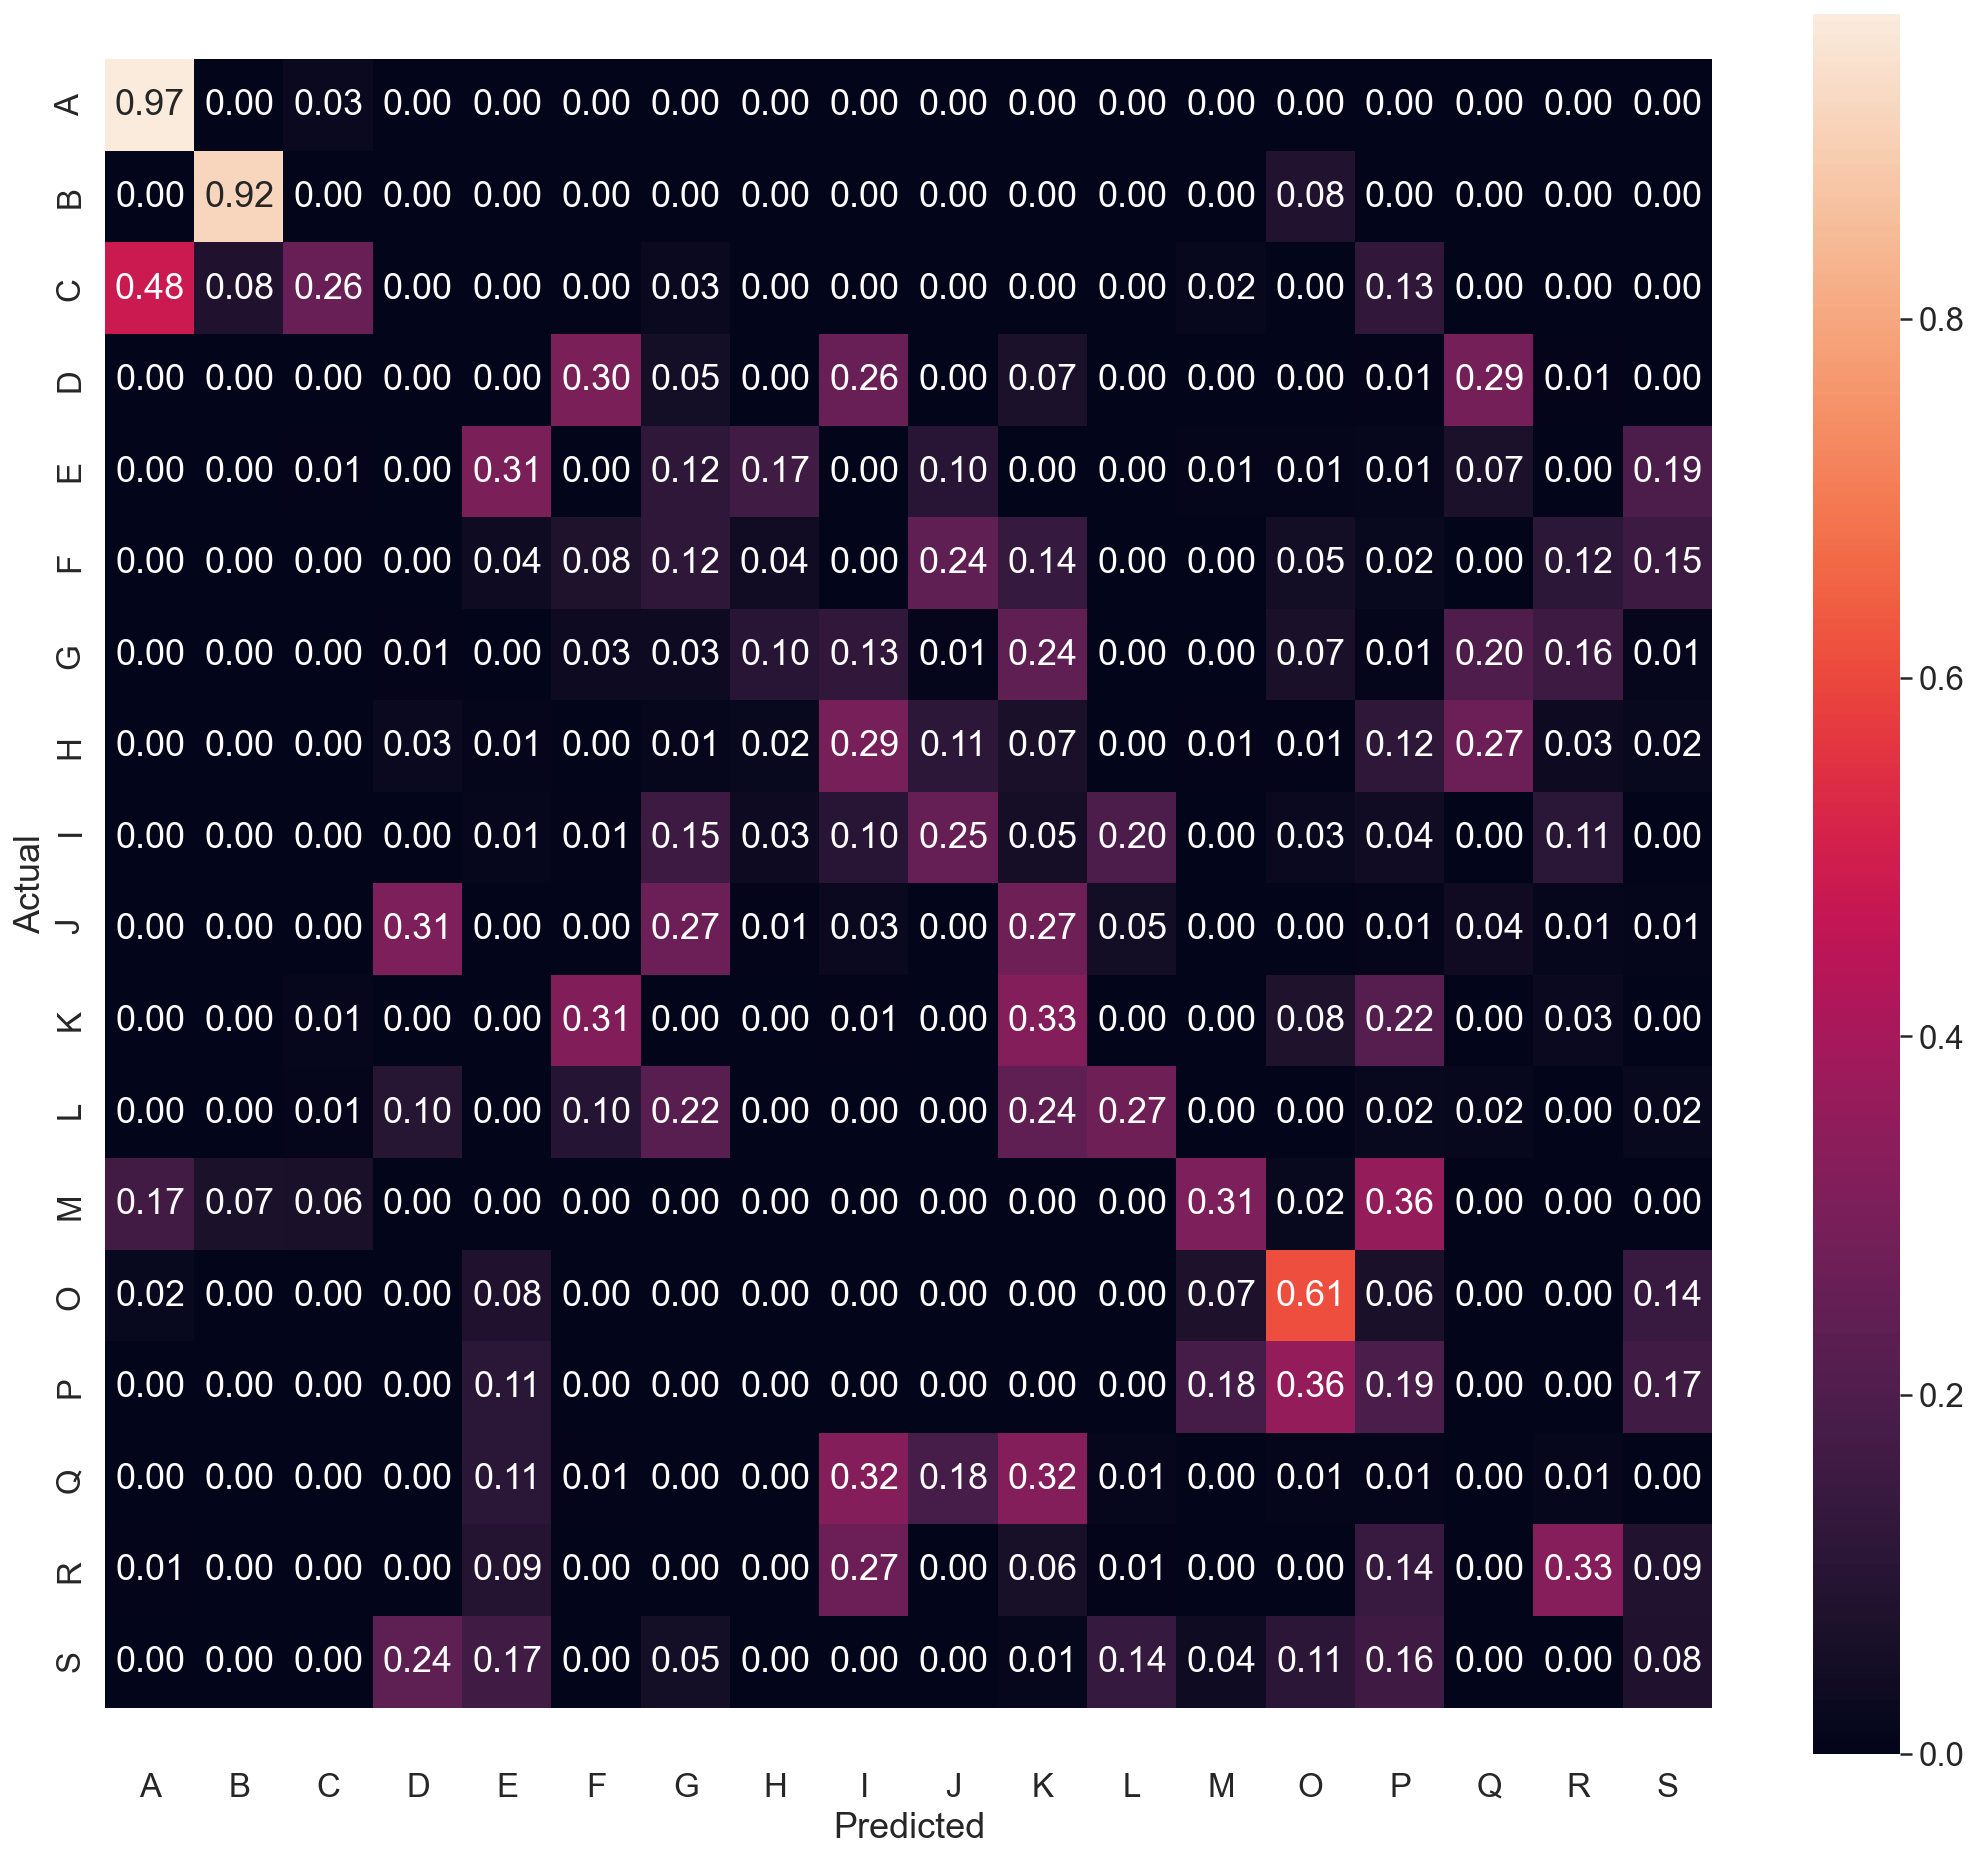

In [271]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0] # activity_map.values() for activity names, but they the CM will be squashed
)

In [272]:
# cm = confusion_matrix(y_val_argmax, y_val_pred_argmax)
# df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
# plt.figure(figsize = (20,20))
# sn.heatmap(df_cm, annot=True, fmt='g')

In [273]:
from sklearn.metrics import classification_report

print("             Results for Test Set\n\n" + 
      classification_report(enc.inverse_transform(y_pred),
                            enc.inverse_transform(y_test)))

             Results for Test Set

              precision    recall  f1-score   support

           A       0.97      0.50      0.66       517
           B       0.92      0.75      0.82       232
           C       0.26      0.66      0.37       140
           D       0.00      0.00      0.00       242
           E       0.31      0.34      0.32       322
           F       0.08      0.11      0.09       251
           G       0.03      0.03      0.03       373
           H       0.02      0.06      0.03       133
           I       0.10      0.09      0.09       432
           J       0.00      0.00      0.00       308
           K       0.33      0.15      0.21       576
           L       0.27      0.40      0.32       241
           M       0.31      0.50      0.38       254
           O       0.61      0.46      0.52       536
           P       0.19      0.14      0.16       542
           Q       0.00      0.00      0.00       294
           R       0.33      0.35      0.34   

## References

#### Papers:


#### Weblinks:

* [The llustrated Transformer](http://jalammar.github.io/illustrated-transformer/)


#### TODO

   1. Implement a custom callback
   2. ~~Compare LSTM of blog post~~
   3. Put code into t2 files
   4. Explain dimensions, give examples. Windowing etc. use TF time_series.ipynb notebooks as example
       - Build WindowGenerator, time_series.ipynb notebook for examples
   5. Give in-depth explaination to adaption for time-series with relation to Transformer achitecture, use http://nlp.seas.harvard.edu/2018/04/03/attention.html and https://srome.github.io/Understanding-Attention-in-Neural-Networks-Mathematically/ as well as http://jalammar.github.io/illustrated-transformer/ and https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/13.time-series-human_activity_recognition.ipynb as reference
   6. Add table of contents to this notebook